# Title: Sample Investigation
LogAnalytics

## Description:
Trace Path of Attacker in Our Organization


<a id='toc'></a>
## Table of Contents
- [Setup and Authenticate](#setup)

- [Get Alerts List](#getalertslist)
- [Choose an Alert to investigate](#enteralertid)
  - [Extract Properties and entities from alert](#extractalertproperties)
  - [Basic IP Checks](#basic_ip_checks)
    - [Check the IP Address for known C2 addresses](#check_ip_ti)
- [See What's going on on the Affected Host - Linux](#alerthost)
  - [Event Types collected](#linux_event_types)
  - [Failure Events](#linux_failure_events)
  - [Extract IPs from all Events](#linux_extract_ips)
  - [Get Logins with IP Address Recorded](#linux_login_ips)
  - [What's happening in these sessions?](#linux_login_sessions)
  - [Find Distinctive Process Patterns - Clustering](#linux_proc_cluster)
- [Alert Host Network Data](#alert_host_net)
  - [Check Communications with Other Hosts](#comms_to_other_hosts)
  - [GeoLocation Mapping](#geomap_lx_ips)
  - [Have any other hosts been communicating with this address(es)?](#other_hosts_to_ips)
- [Other Hosts Communicating with IP](#other_host_investigate)
  - [Check Host Logons](#host_logons)
  - [Examine a Logon Session](#examine_win_logon_sess)
  - [Unusual Processes on Host - Clustering](#process_clustering)
  - [Processes for Selected LogonId](#process_session)
  - [Other Events on the Host](#other_win_events)
- [Office 365 Activity](#o365)
- [Summary](#summary)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


### Import Python Packages

In [ ]:
# NOTE: Required Packages - You may need to run these for things to work!
# !pip install dnspython
# !pip install ipwhois
# !pip install folium --upgrade
# !pip install maxminddb-geolite2
# !pip install --upgrade pandas

In [ ]:
# Imports
import sys
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import msticpy.sectools as sectools
import msticpy.asitools as asi
import msticpy.asitools.kql as qry
import msticpy.asitools.nbdisplay as asidisp

WIDGET_DEFAULTS = {'layout': widgets.Layout(width='95%'),
                   'style': {'description_width': 'initial'}}
display(HTML(asi.util._TOGGLE_CODE_PREPARE_STR))


In [ ]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
from collections import OrderedDict

def copy_to_clipboard(copy_text):
    pd.DataFrame([copy_text]).to_clipboard(index=False,header=False)
    
LA_URL=('https://ms.portal.azure.com/'
        '?feature.showassettypes=Microsoft_Azure_Security_Insights_SecurityInsightsDashboard'
        '#blade/Microsoft_Azure_Security_Insights/MainMenuBlade/6'
        '/subscriptionId/{sub_id}'
        '/resourceGroup/{ws_id}'
        '/workspaceName/{ws_name}')

@register_line_cell_magic
def la(line, cell=None):
    KQL_MAGIC_RESULT = '_kql_raw_result_'
    
    #import pdb; pdb.set_trace()
    if not cell and not line or line.strip() == KQL_MAGIC_RESULT:
        if KQL_MAGIC_RESULT in globals():
            copy_to_clipboard(globals()[KQL_MAGIC_RESULT].query)
            print('Last kql query copied to clipboard.')
    elif line and cell is None:
        if line in globals():
            copy_to_clipboard(globals()[line])
            print(f'Value of {line} copied to clipboard.')
        elif line in locals():
            copy_to_clipboard(locals()[line])
            print(f'Value of {line} copied to clipboard.')
        else:
            copy_to_clipboard(line)
            print(f'Copied to clipboard.')
    else:
        copy_to_clipboard(cell)
        print(f'Copied to clipboard.')
    
    url = LA_URL # TODO .format(sub_id=subscription_id,
#                         ws_id=resource_group, 
#                         ws_name=workspace_name)
    return HTML(f'<a target="_new" href="{url}">Open Log Analytics</a>')
del la

# Create an observation collector list
from collections import namedtuple
Observation = namedtuple('Observation', ['caption', 'description', 'item', 'link'])
observation_list = OrderedDict()
def display_observation(observation):
    display(Markdown(f'### {observation.caption}'))
    display(Markdown(observation.description))
    display(Markdown(f'[Go to details](#{observation.link})'))
    display(observation.item)

def add_observation(observation):
    observation_list[observation.caption] = observation


### Enter or confirm WorkspaceId
To find your Workspace Id go to [Log Analytics](#https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.

In [ ]:

available_workspaces = {'Contoso77':'802d39e1-9d70-404d-832c-2de5e2478eda', 
                        'MSTICLinux':'06dc719f-5dad-47e9-b5af-07d84a0bda4e',
                        'ASIHuntOMSWorkspaceV4': '52b1ab41-869e-4138-9e40-2a4457f09bf0',
                        'ASIHuntOMSWorkspaceV5': '4ca7b24a-6e8f-4540-a8ce-1a80c2948c37',
                        'Rome ILDC - Detection E2E Tests Stage': '3eb61071-5dcd-4db3-94fa-0091a69b7359'}
select_ws = asi.SelectString(description='Select workspace :',
                             item_dict=available_workspaces)

select_ws.display()

In [ ]:
import os
from msticpy.asitools.asiconfig import WorkspaceConfig
ws_config_file = 'config.json'
try:
    ws_config = WorkspaceConfig(ws_config_file)
    print('Found config file')
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group', 'workspace_id', 'workspace_name']:
        print(cf_item, ws_config[cf_item])
except:
    ws_config = None

ws_id = asi.GetEnvironmentKey(env_var='WORKSPACE_ID',
                              prompt='Log Analytics Workspace Id:')
if ws_config:
    ws_id.value = ws_config['workspace_id']
ws_id.display()

### Authenticate to Log Analytics
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

In [ ]:
try:
    WORKSPACE_ID = select_ws.value
except NameError:
    try:
        WORKSPACE_ID = ws_id.value
    except NameError:
        WORKSPACE_ID = None
    
if not WORKSPACE_ID:
    raise ValueError('No workspace selected.')

asi.kql.load_kql_magic()

%kql loganalytics://code().workspace(WORKSPACE_ID)


<a id='getalertslist'></a>[Contents](#toc)
# Get Alerts List

Specify a time range to search for alerts. One this is set run the following cell to retrieve any alerts in that time window.
You can change the time range and re-run the queries until you find the alerts that you want.

In [ ]:
alert_q_times = asi.QueryTime(units='day', max_before=20, before=2, max_after=1)
alert_q_times.display()

In [ ]:
alert_counts = qry.list_alerts_counts(provs=[alert_q_times])
alert_list = qry.list_alerts(provs=[alert_q_times])
print(len(alert_counts), ' distinct alert types')
print(len(alert_list), ' distinct alerts')
display(HTML('<h2>Top alerts</h2>'))
alert_counts.head(10) # remove '.head()'' to see the full list grouped by AlertName

<a id='enteralertid'></a>[Contents](#toc)
# Choose Alert to Investigate
Pick an alert from a list of retrieved alerts.

This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

In particular, we use the alert to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

### Select alert from list
As you select an alert, the main properties will be shown below the list.

Use the filter box to narrow down your search to any substring in the AlertName.

In [207]:
security_alert = None
def show_full_alert(selected_alert):
    global security_alert
    security_alert = asi.SecurityAlert(alert_select.selected_alert)
    asi.disp.display_alert(security_alert, show_entities=True)
alert_select = asi.AlertSelector(alerts=alert_list, action=show_full_alert)
alert_select.display()

#### Check alert for IP addresses not contained in entities
Additional IP addresses found in alert are shown below.

If you have others to check (e.g. from Threat Intel data) that
you think may be associated with the same investigation, add them here (delimited by commas).

In [208]:
# Extract any additional IP entities
ioc_extractor = sectools.IoCExtract()
new_entities = ioc_extractor.extract(src=str(security_alert))

addl_ip_addrs = ', '.join(new_entities.get('ipv4', []))

if (not [e for e in security_alert.entities if isinstance(e, asi.IpAddress)] and
    not addl_ip_addrs):
    print('WARNING: Alert has no IpAddress entities.')
    print()


print('Additional IP addresses')
ip_wgt = widgets.Text(description='IP Addresses:', value=addl_ip_addrs, **WIDGET_DEFAULTS)
display(ip_wgt)

Additional IP addresses


Text(value='13.67.35.176', description='IP Addresses:', layout=Layout(width='95%'), style=DescriptionStyle(des…

<a id='basic_ip_checks'></a>[Contents](#toc)
## Basic IP Checks

### Geo-mapping function definition

In [209]:
from msticpy.sectools.geoip import GeoLiteLookup
iplocation = GeoLiteLookup()

alert_ip_entities = [e for e in security_alert.entities if isinstance(e, asi.IpAddress)]
for ip_entity in alert_ip_entities:
    if 'Location' not in ip_entity or not ip_entity.Location:
        print(ip_entity)
        iplocation.lookup_ip(ip_entity=ip_entity)

if ip_wgt.value:
    ip_str_list = [ip.strip() for ip in ip_wgt.value.split(',') if ip]
    if ip_str_list:
        _, ip_entities = iplocation.lookup_ip(ip_addr_list=ip_str_list)
        alert_ip_entities = alert_ip_entities + ip_entities

import folium
from folium.plugins import MarkerCluster
from numbers import Number
import warnings

def create_ip_map():
    folium_map = folium.Map(zoom_start=7, tiles=None, width='100%', height='100%')
    folium_map.add_tile_layer(name='IPEvents')
    return folium_map

def add_ip_cluster(folium_map, ip_entities, alert=None, **icon_props):
    if not folium_map:
        folium_map = create_ip_map()
    
    for ip_entity in ip_entities:
        if not (isinstance(ip_entity.Location.Latitude, Number) and
                isinstance(ip_entity.Location.Longitude, Number)):
            warnings.warn("Invalid location information for IP: " + ip_entity.Address,
                          RuntimeWarning)
            continue
        loc_props = ', '.join([f'{key}={val}' for key, val in 
                               ip_entity.Location.properties.items() if val])
        popup_text = "{loc_props}<br>{IP}".format(IP=ip_entity.Address,
                                                  loc_props=loc_props)
        tooltip_text = '{City}, {CountryName}'.format(**ip_entity.Location.properties)
        if alert:
            popup_text = f'{popup_text}<br>{alert.AlertName}'
        if ip_entity.AdditionalData:
            addl_props = ', '.join([f'{key}={val}' for key, val in 
                                    ip_entity.AdditionalData.items() if val])
            popup_text = f'{popup_text}<br>{addl_props}'
            tooltip_text = f'{tooltip_text}, {addl_props}'
        marker = folium.Marker(
            location = [ip_entity.Location.Latitude, ip_entity.Location.Longitude],
            popup=popup_text,
            tooltip=tooltip_text,
            icon=folium.Icon(**icon_props)
        )
        marker.add_to(folium_map)

    return folium_map

ip_loc_map = create_ip_map()
icon_props = {'color': 'red', 'icon': 'crosshairs', 'prefix': 'fa'}
ip_loc_map = add_ip_cluster(folium_map=ip_loc_map,
                            ip_entities=alert_ip_entities,
                            alert=security_alert,
                            **icon_props)
display(HTML('<h3>Location of IP Address in alert</h3>'))
display(ip_loc_map)

add_observation(Observation(caption='Alert IPs Location', 
                            description='Geolocation of alert IPs',
                            item=alert_ip_entities,
                            link='basic_ip_checks'))


### Reverse IP and WhoIs

In [210]:
# reverse DNS lookup
from dns import reversename, resolver
from ipwhois import IPWhois
for src_ip_entity in alert_ip_entities:
    print('IP:', src_ip_entity.Address)
    print('-'*50)
    
    print('Reverse Name Lookup.')
    rev_name = reversename.from_address(src_ip_entity.Address)
    
    print(rev_name)
    try:
        rev_dns = str(resolver.query(rev_name, 'PTR'))
        display(rev_dns)
    except:
        print('No reverse addr result')
        pass

    print('\nWhoIs Lookup.')
    whois = IPWhois(src_ip_entity.Address)
    whois_result = whois.lookup_whois()
    if whois_result:
        display(whois_result)
    else:
        print('No whois result')


IP: 13.67.35.176
--------------------------------------------------
Reverse Name Lookup.
176.35.67.13.in-addr.arpa.
No reverse addr result

WhoIs Lookup.


{'nir': None,
 'asn_registry': 'arin',
 'asn': '8075',
 'asn_cidr': '13.64.0.0/11',
 'asn_country_code': 'US',
 'asn_date': '2015-03-26',
 'asn_description': 'MICROSOFT-CORP-MSN-AS-BLOCK - Microsoft Corporation, US',
 'query': '13.67.35.176',
 'nets': [{'cidr': '13.64.0.0/11, 13.104.0.0/14, 13.96.0.0/13',
   'name': 'MSFT',
   'handle': 'NET-13-64-0-0-1',
   'range': '13.64.0.0 - 13.107.255.255',
   'description': 'Microsoft Corporation',
   'country': 'US',
   'state': 'WA',
   'city': 'Redmond',
   'address': 'One Microsoft Way',
   'postal_code': '98052',
   'emails': ['msndcc@microsoft.com',
    'IOC@microsoft.com',
    'abuse@microsoft.com'],
   'created': '2015-03-26',
   'updated': '2015-03-26'}],
 'raw': None,
 'referral': None,
 'raw_referral': None}

<a id='check_ip_ti'></a>[Contents](#toc)
### Check the IP Address for known C2 addresses

In [211]:
# Lookup in BYOTI or VT (or IPRep)
fake_ip = '203.0.113.5'
ti_query = r'''
ThreatIntelSample_CL
| where NetworkIP_s == '{ip}'
| project
TimeGenerated,
ExternalIndicatorId_s,
ThreatType_s,
Description_s,
Active_s,
TrafficLightProtocolLevel_s,
ConfidenceScore_s,
ThreatSeverity_s,
ExpirationDateTime_t,
IndicatorId_s,
NetworkIP_s,
Type
'''.format(ip=fake_ip)
%kql -query ti_query
ti_query_df = _kql_raw_result_.to_dataframe()
if len(ti_query_df) > 0:
    display(ti_query_df.T)
    
    add_observation(Observation(caption='Threat Intel Report on IP(s)', 
                            description='Threat intelligence report found on alert host ext IP',
                            item=ti_query_df,
                            link='check_ip_ti'))


,0
TimeGenerated,2019-02-07 01:15:18.400000
ExternalIndicatorId_s,TestBotnetIndicator1549501989MS531
ThreatType_s,Botnet
Description_s,This is a test botnet indicator generated in RFC5737 documentation space. Take no action on any ...
Active_s,True
TrafficLightProtocolLevel_s,Green
ConfidenceScore_s,0
ThreatSeverity_s,0
ExpirationDateTime_t,2019-02-07 02:13:08.531000
IndicatorId_s,6eb18b18cf93deb3bd8d22f56160dbb2392fa99de510c710e00d297f5c5ba8db


<a id='alerthost'></a>[Contents](#toc)
# See What's going on on the Affected Host - Linux

In [212]:
host1_q_times = asi.QueryTime(label='Set time bounds for alert host - at least 1hr either side of the alert',
                           units='hour', max_before=48, before=2, after=1, 
                           max_after=24, origin_time=security_alert.StartTimeUtc)
host1_q_times.display()

HTML(value='<h4>Set time bounds for alert host - at least 1hr either side of the alert</h4>')

In [213]:
# Linux test
linux_events = r'''
AuditLog_CL
| where Computer has '{hostname}'
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| extend mssg_parts = extract_all(@"type=(?P<type>[^\s]+)\s+msg=audit\((?P<mssg_id>[^)]+)\):\s+(?P<mssg>[^\r]+)\r?", dynamic(['type', 'mssg_id', 'mssg']), RawData)
| extend mssg_type = tostring(mssg_parts[0][0]), mssg_id = tostring(mssg_parts[0][1])
| project TenantId, TimeGenerated, Computer, mssg_type, mssg_id, mssg_parts
| extend mssg_content = split(mssg_parts[0][2],' ')
| extend typed_mssg = pack(mssg_type, mssg_content)
| summarize AuditdMessage = makelist(typed_mssg) by TenantId, TimeGenerated, Computer, mssg_id
'''.format(start=host1_q_times.start, end=host1_q_times.end,
           hostname=security_alert.hostname)
%kql -query linux_events
linux_events_df = _kql_raw_result_.to_dataframe()
print(f'{len(linux_events_df)} raw auditd mssgs downloaded')


17469 raw auditd mssgs downloaded


In [214]:
import codecs
from datetime import datetime
encoded_params = {'EXECVE': {'a0', 'a1', 'a2', 'a3', 'arch'},
                  'PROCTITLE': {'proctitle'},
                  'USER_CMD': {'cmd'}}

def unpack_auditd(audit_str):
    event_dict = {}
    for record in audit_str:
        
        for rec_key, rec_val in record.items():
            rec_dict = {}
            encoded_fields_map = encoded_params.get(rec_key, None)
            for rec_item in rec_val:
                rec_split = rec_item.split('=', maxsplit=1)
                if len(rec_split) == 1:
                    rec_dict[rec_split[0]] = None
                    continue
                if (not encoded_fields_map or rec_split[1].startswith('"') or
                        rec_split[0] not in encoded_fields_map):
                    field_value = rec_split[1].strip('\"')
                else:
                    try:
                        field_value = codecs.decode(rec_split[1], 'hex').decode('utf-8')
                    except:
                        field_value = rec_split[1]
                        print(rec_val)
                        print('ERR:', rec_key, rec_split[0], rec_split[1], type(rec_split[1]))
                rec_dict[rec_split[0]] = field_value
            event_dict[rec_key] = rec_dict
        
    return event_dict

USER_START = {'pid': 'int', 'uid': 'int', 'auid': 'int', 
              'ses': 'int', 'msg': None, 'acct': None, 'exe': None, 
              'hostname': None, 'addr': None, 'terminal': None, 
              'res': None}
FIELD_DEFS = {'SYSCALL': {'success': None, 'ppid': 'int', 'pid': 'int', 
                          'auid': 'int', 'uid': 'int', 'gid': 'int',
                          'euid': 'int', 'egid': 'int', 'ses': 'int',
                          'exe': None, 'com': None},
              'CWD': {'cwd': None},
              'PROCTITLE': {'proctitle': None},
              'LOGIN': {'pid': 'int', 'uid': 'int', 'tty': None, 'old-ses': 'int', 
                        'ses': 'int', 'res': None},
              'EXECVE': {'argc': 'int', 'a0': None, 'a1': None, 'a2': None},
              'USER_START': USER_START,
              'USER_END': USER_START,
              'CRED_DISP': USER_START,
              'USER_ACCT': USER_START,
              'CRED_ACQ': USER_START,
              'USER_CMD': {'pid': 'int', 'uid': 'int', 'auid': 'int', 
                           'ses': 'int', 'msg': None, 'cmd': None,
                           'terminal': None, 'res': None},
             }

def extract_event(message_dict):
    if 'SYSCALL' in message_dict:
        proc_create_dict = {}
        for mssg_type in ['SYSCALL', 'CWD', 'EXECVE', 'PROCTITLE']:
            if (not mssg_type in message_dict or
                    not mssg_type in FIELD_DEFS) :
                continue
            for fieldname, conv in FIELD_DEFS[mssg_type].items():
                value = message_dict[mssg_type].get(fieldname, None)
                if not value:
                    continue
                if conv:
                    if conv == 'int':
                        value = int(value)
                        if value == 4294967295:
                            value = -1
                proc_create_dict[fieldname] = value
            if mssg_type == 'EXECVE':
                args = int(proc_create_dict.get('argc', 1))
                arg_strs = []
                for arg_idx in range(0, args):
                    arg_strs.append(proc_create_dict.get(f'a{arg_idx}', ''))
                    
                proc_create_dict['cmdline'] = ' '.join(arg_strs)
        return 'SYSCALL', proc_create_dict
    else:
        event_dict = {}                                            
        for mssg_type, mssg in message_dict.items():
            if mssg_type in FIELD_DEFS:
                for fieldname, conv in FIELD_DEFS[mssg_type].items():
                    value = message_dict[mssg_type].get(fieldname, None)
                    if conv:
                        if conv == 'int':
                            value = int(value)
                            if value == 4294967295:
                                value = -1
                    event_dict[fieldname] = value
            else:
                
                event_dict.update(message_dict[mssg_type])
        return list(message_dict.keys())[0], event_dict

    
def move_cols_to_front(df, column_count):
    """Reorder columms to put the last column count cols to front."""
    return df[list(df.columns[-column_count:]) + list(df.columns[:-column_count])]


def extract_events_to_df(data, event_type=None, verbose=False):
    
    if verbose:
        start_time = datetime.utcnow()
        print(f'Unpacking auditd messages for {len(data)} events...')
    tmp_df = (data.apply(lambda x: extract_event(unpack_auditd(x.AuditdMessage)), 
                         axis=1, result_type='expand')
                  .rename(columns={0: 'EventType', 
                                   1: 'EventData'})
                  )
    # if only one type of event is requested
    if event_type:
        tmp_df = tmp_df[tmp_df['EventType'] == event_type]
        if verbose:
            print(f'Event subset = ', event_type, ' (events: {len(tmp_df)})')
    
    if verbose:
        print('Building output dataframe...')
        
    tmp_df = (tmp_df.apply(lambda x: pd.Series(x.EventData), axis=1)
              .merge(tmp_df[['EventType']], left_index=True, right_index=True)
              .merge(data.drop(['AuditdMessage'], axis=1), 
                 how='inner', left_index=True, right_index=True)
              .dropna(axis=1, how='all'))
    
    if verbose:
        print('Fixing timestamps...')
        
    # extract real timestamp from mssg_id
    tmp_df['TimeStamp'] = (tmp_df.apply(lambda x:
                                        datetime.utcfromtimestamp(float(x.mssg_id.split(':')[0])),
                                        axis=1))
    tmp_df = (tmp_df.drop(['TimeGenerated'], axis=1)
                    .rename(columns={'TimeStamp': 'TimeGenerated'})
                    .pipe(move_cols_to_front, column_count=5))
    if verbose:
        print(f'Complete. {len(tmp_df)} output rows', end=' ')
        delta = datetime.utcnow() - start_time
        print(f'time: {delta.seconds + delta.microseconds/1_000_000} sec')
        
    return tmp_df


def get_event_subset(data, event_type):
    return (data[data['EventType'] == event_type]
             .dropna(axis=1, how='all')
             .infer_objects())



In [215]:
linux_events_all = extract_events_to_df(linux_events_df, verbose=True)

Unpacking auditd messages for 17469 events...
Building output dataframe...
Fixing timestamps...
Complete. 17469 output rows time: 10.81584 sec


<a id='linux_event_types'></a>[Contents](#toc)
### Event Types collected

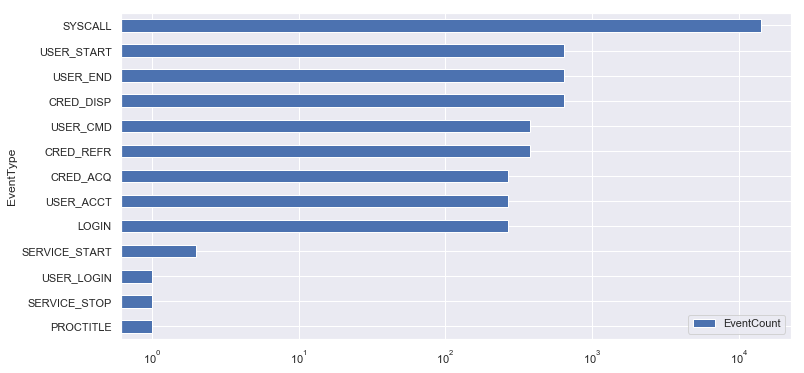

In [216]:
sns.set()
(linux_events_all[['EventType', 'TimeGenerated']]
     .groupby('EventType').count().rename(columns={'TimeGenerated': 'EventCount'})
     .sort_values('EventCount', ascending=True)
     .plot.barh(logx=True, figsize=(12,6)));

View events by Type - Process (SYSCALL) and Login events are covered in more detail below.
Use this to look at some of the rarer event types to see anything unusual.

In [217]:


from ipywidgets import interactive

items = sorted(linux_events_all['EventType'].unique().tolist())

def view(x=''):
    display(linux_events_all[linux_events_all['EventType']==x]
            .drop(['EventType', 'TenantId', 'Computer', 'mssg_id'], axis=1)
            .dropna(axis=1, how='all'))

w = widgets.Select(options=items, description='Select Event Type', **WIDGET_DEFAULTS)
interactive(view, x=w)

interactive(children=(Select(description='Select Event Type', layout=Layout(width='95%'), options=('CRED_ACQ',…

#### Extract Individual Event Types

In [218]:
lx_proc_create = get_event_subset(linux_events_all,'SYSCALL')
print(f'{len(lx_proc_create)} Process Create Events')

lx_login = (get_event_subset(linux_events_all, 'LOGIN')
        .merge(get_event_subset(linux_events_all, 'CRED_ACQ'), 
               how='inner',
               left_on=['old-ses', 'pid', 'uid'], 
               right_on=['ses', 'pid', 'uid'],
               suffixes=('', '_cred')).drop(['old-ses','TenantId_cred', 
                                             'Computer_cred'], axis=1)
        .dropna(axis=1, how='all'))
print(f'{len(lx_login)} Login Events')


13976 Process Create Events
265 Login Events


<a id='linux_failure_events'></a>[Contents](#toc)
### Failure Events
Can sometimes tell us about attempts to probe around the system that haven't quite worked.
Login failures will show up here as well.

In [219]:
                   

lx_fail_events = (linux_events_all[linux_events_all['res'] == "failed'"]
                    .drop(['TenantId', 'mssg_id'], axis=1)
                    .dropna(axis=1, how='all'))
if len(lx_fail_events) > 0:
    display(lx_fail_events)
    add_observation(Observation(caption='Failure events on Linux host.',
                               description='One or more failure events detected on host.',
                               item=lx_fail_events,
                               link='linux_failure_events'))

<a id='linux_extract_ips'></a>[Contents](#toc)
### Extract IPs from all Events

In [220]:
                   

# Search all events for addr with an IPAddress. 
# Drop duplicates and localhost and return list
events_with_ips = (linux_events_all[['EventType','addr']]
                   [linux_events_all['addr'].str.contains('\.', na=False)]
                   .drop_duplicates())
display(events_with_ips)
host_ext_ips = list(events_with_ips['addr'].drop_duplicates().to_dict().values())
if '127.0.0.1' in host_ext_ips:
    host_ext_ips.remove('127.0.0.1')
display(host_ext_ips)


,EventType,addr
3642,USER_ACCT,23.97.60.214
3643,CRED_ACQ,23.97.60.214
4918,USER_START,23.97.60.214
5039,USER_END,23.97.60.214
5040,CRED_DISP,23.97.60.214
11102,USER_LOGIN,23.97.60.214


['23.97.60.214']

<a id='linux_login_ips'></a>[Contents](#toc)
### Get Logins with IP Address Recorded

In [222]:
                   

logins_with_ips = (lx_login[lx_login['addr'] != '?']
                   [['Computer', 'TimeGenerated','pid', 'ses', 
                     'acct', 'addr', 'exe', 'hostname', 'msg',
                     'res_cred', 'ses_cred', 'terminal']])
if len(logins_with_ips) > 0:
    display(logins_with_ips)
    add_observation(Observation(caption='Login events with source Ip addresses',
                                description=f'{len(logins_with_ips)} logins with external addresses',
                                item=logins_with_ips,
                                link='linux_login_ips'))


,Computer,TimeGenerated,pid,ses,acct,addr,exe,hostname,msg,res_cred,ses_cred,terminal
63,MSTICAlertsLxVM2,2019-02-16 03:51:55.865,22838,190715,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh
169,MSTICAlertsLxVM2,2019-02-16 03:23:17.590,19803,190671,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh


<a id='linux_login_sessions'></a>[Contents](#toc)
### What's happening in these sessions?
If there are a lot of events here try the [Process Clustering](#linux_proc_cluster) section below.

In [224]:
# copy/replace this value with the ses/SubjectLogonId value


items = sorted(lx_login[lx_login['addr'] != '?']['ses'].unique().tolist())

def view(x=''):
    procs = (lx_proc_create[lx_proc_create['ses']==x]
                [['TimeGenerated', 'exe','cmdline', 'pid','cwd']])
    display(Markdown(f'{len(procs)} process events'))
    display(procs)

w = widgets.Select(options=items, description='Select Session', **WIDGET_DEFAULTS)
interactive(view, x=w)


interactive(children=(Select(description='Select Session', layout=Layout(width='95%'), options=(190671, 190715…

Convert Auditd to Windows-like events

In [225]:
                   

lx_to_proc_create = {'acct': 'SubjectUserName',
                     'uid': 'SubjectUserSid',
                     'user': 'SubjectUserName',
                     'ses': 'SubjectLogonId',
                     'pid': 'NewProcessId',
                     'exe': 'NewProcessName',
                     'ppid': 'ProcessId',
                     'cmdline': 'CommandLine',}

proc_create_to_lx = {'SubjectUserName': 'acct',
                     'SubjectUserSid': 'uid',
                     'SubjectUserName': 'user',
                     'SubjectLogonId': 'ses',
                     'NewProcessId': 'pid',
                     'NewProcessName': 'exe',
                     'ProcessId': 'ppid',
                     'CommandLine': 'cmdline',}

lx_to_logon = {'acct': 'SubjectUserName',
               'auid': 'SubjectUserSid',
               'user': 'TargetUserName',
               'uid': 'TargetUserSid',
               'ses': 'TargetLogonId',
               'exe': 'LogonProcessName',
               'terminal': 'LogonType',
               'msg': 'AuthenticationPackageName',
               'res': 'Status',
               'addr': 'IpAddress',
               'hostname': 'WorkstationName',}

logon_to_lx = {'SubjectUserName': 'acct',
               'SubjectUserSid': 'auid',
               'TargetUserName': 'user',
               'TargetUserSid': 'uid',
               'TargetLogonId': 'ses',
               'LogonProcessName': 'exe',
               'LogonType': 'terminal',
               'AuthenticationPackageName': 'msg',
               'Status': 'res',
               'IpAddress': 'addr',
               'WorkstationName': 'hostname',}

lx_proc_create_trans = lx_proc_create.rename(columns=lx_to_proc_create)
lx_login_trans = lx_login.rename(columns=lx_to_logon)

<a id='linux_proc_cluster'></a>[Contents](#toc)
## Find Distinctive Process Patterns - Clustering

In [226]:
                   

from msticpy.sectools.eventcluster import dbcluster_events, add_process_features

feature_procs_h1 = add_process_features(input_frame=lx_proc_create_trans,
                                        path_separator=security_alert.path_separator)


# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs_h1,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                    'SubjectUserSid'],
                                                    time_column='TimeGenerated',
                                                    max_cluster_distance=0.0001)
print('Number of input events:', len(feature_procs_h1))
print('Number of clustered events:', len(clus_events))
(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                           'NewProcessName', 'CommandLine', 
                                           'ClusterSize', 'commandlineTokensFull',
                                           'SubjectLogonId', 'SubjectUserSid',
                                           'pathScore', 'isSystemSession']]
    .sort_values('ClusterSize', ascending=True));

Number of input events: 13976
Number of clustered events: 155


In [229]:
                   

def view(x=''):
    procs = (clus_events[clus_events['SubjectLogonId']==x]
            [['TimeGenerated', 'NewProcessName','CommandLine', 
              'NewProcessId', 'SubjectUserSid', 'cwd', 'ClusterSize', 'SubjectLogonId']])
    display(Markdown(f'{len(procs)} process events'))
    display(procs)

w = widgets.Select(options=items, description='Select Session to view', **WIDGET_DEFAULTS)
interactive(view, x=w)

interactive(children=(Select(description='Select Session to view', layout=Layout(width='95%'), options=(190671…

In [230]:
selected_session = w.value
add_observation(Observation(caption='Suspicious Process Session on Linux Host.',
                            description='Attempt to download and run script + recon cmds.',
                            item = clus_events.query('SubjectLogonId == @selected_session & ClusterSize < 3'),
                            link='linux_proc_cluster'))

<a id='alert_host_net'></a>[Contents](#toc)
# Alert Host Network Data

## Get the IP Address of the Source Host

In [231]:
                   

host_entities = [e for e in security_alert.entities if isinstance(e, asi.Host)]
if len(host_entities) == 1:
    alert_host_entity = host_entities[0]
    host_name = alert_host_entity.HostName
    resource = alert_host_entity.AzureID
else:
    host_name = None
    alert_host_entity = None
    print('Error: Could not determine host entity from alert. Please type the hostname below')
txt_wgt = widgets.Text(value=host_name, description='Confirm Source Host name:', **WIDGET_DEFAULTS)
display(txt_wgt)

Text(value='MSTICALERTSLXVM2', description='Confirm Source Host name:', layout=Layout(width='95%'), style=Desc…

In [232]:
             

print('Looking for IP addresses of ', txt_wgt.value)
aznet_query = '''
AzureNetworkAnalytics_CL 
| where VirtualMachine_s has \'{host}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s
'''.format(host=txt_wgt.value)
%kql -query aznet_query
az_net_df = _kql_raw_result_.to_dataframe()


oms_heartbeat_query = '''
Heartbeat
| where Computer has \'{host}\'
| top 1 by TimeGenerated desc nulls last
| project ComputerIP, OSType, OSMajorVersion, OSMinorVersion, ResourceId, RemoteIPCountry, 
RemoteIPLatitude, RemoteIPLongitude, SourceComputerId
'''.format(host=txt_wgt.value)
%kql -query oms_heartbeat_query
oms_heartbeat_df = _kql_raw_result_.to_dataframe()
display(oms_heartbeat_df[['ComputerIP']])
display(az_net_df)


# Get the host entity and add this IP and system info to the 
try:
    if not inv_host_entity:
        inv_host_entity = asi.Host()
        inv_host_entity.HostName = host_name
except NameError:
    inv_host_entity = asi.Host()
    inv_host_entity.HostName = host_name

def convert_to_ip_entities(ip_str):
    ip_entities = []
    if ip_str:
        if ',' in ip_str:
            addrs = ip_str.split(',')
        elif ' ' in ip_str:
            addrs = ip_str.split(' ')
        else:
            addrs = [ip_str]
        for addr in addrs:
            ip_entity = asi.IpAddress()
            ip_entity.Address = addr.strip()
            iplocation.lookup_ip(ip_entity=ip_entity)
            ip_entities.append(ip_entity)
    return ip_entities

# Add this information to our inv_host_entity
if len(az_net_df) == 1:
    priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
    inv_host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

    pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
    inv_host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)

retrieved_address = [ip.Address for ip in inv_host_entity.properties['public_ips']]
if len(oms_heartbeat_df) == 1:
    if oms_heartbeat_df['ComputerIP'].loc[0]:
        oms_address = oms_heartbeat_df['ComputerIP'].loc[0]
        if oms_address not in retrieved_address:
            ip_entity = asi.IpAddress()
            ip_entity.Address = oms_address
            iplocation.lookup_ip(ip_entity=ip_entity)
            inv_host_entity.properties['public_ips'].append(ip_entity)
        
    inv_host_entity.OSFamily = oms_heartbeat_df['OSType'].loc[0]
    inv_host_entity.AdditionalData['OSMajorVersion'] = oms_heartbeat_df['OSMajorVersion'].loc[0]
    inv_host_entity.AdditionalData['OSMinorVersion'] = oms_heartbeat_df['OSMinorVersion'].loc[0]
    inv_host_entity.AdditionalData['SourceComputerId'] = oms_heartbeat_df['SourceComputerId'].loc[0]

print('Updated Host Entity\n')
print(inv_host_entity)

Looking for IP addresses of  MSTICALERTSLXVM2


,ComputerIP
0,104.211.30.1


,PrivateIPAddresses,PublicIPAddresses
0,10.0.3.4,104.211.30.1


Updated Host Entity

{ 'AdditionalData': { 'OSMajorVersion': '18',
                      'OSMinorVersion': '04',
                      'SourceComputerId': '44623fb0-bd5f-49ea-84d1-56aa11ab8a25'},
  'HostName': 'MSTICALERTSLXVM2',
  'OSFamily': 'Linux',
  'Type': 'host',
  'private_ips': [{"Address": "10.0.3.4", "Type": "ipaddress"}],
  'public_ips': [ {"Address": "104.211.30.1", "Location": {"CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163, "Type": "geolocation"}, "Type": "ipaddress"}]}


<a id='comms_to_other_hosts'></a>[Contents](#toc)
## Check Communications with Other Hosts

In [233]:
                   

# Azure Network Analytics Base Query
az_net_analytics_query =r'''
AzureNetworkAnalytics_CL 
| where SubType_s == 'FlowLog'
| where FlowStartTime_t >= datetime({start})
| where FlowEndTime_t <= datetime({end})
| project TenantId, TimeGenerated, 
    FlowStartTime = FlowStartTime_t, 
    FlowEndTime = FlowEndTime_t, 
    FlowIntervalEndTime = FlowIntervalEndTime_t, 
    FlowType = FlowType_s,
    ResourceGroup = split(VM_s, '/')[0],
    VMName = split(VM_s, '/')[1],
    VMIPAddress = VMIP_s, 
    PublicIPs = extractall(@"([\d\.]+)[|\d]+", dynamic([1]), PublicIPs_s),
    SrcIP = SrcIP_s,
    DestIP = DestIP_s,
    ExtIP = iif(FlowDirection_s == 'I', SrcIP_s, DestIP_s),
    L4Protocol = L4Protocol_s, 
    L7Protocol = L7Protocol_s, 
    DestPort = DestPort_d, 
    FlowDirection = FlowDirection_s,
    AllowedOutFlows = AllowedOutFlows_d, 
    AllowedInFlows = AllowedInFlows_d,
    DeniedInFlows = DeniedInFlows_d, 
    DeniedOutFlows = DeniedOutFlows_d,
    RemoteRegion = AzureRegion_s,
    VMRegion = Region_s
| extend AllExtIPs = iif(isempty(PublicIPs), pack_array(ExtIP), 
                         iif(isempty(ExtIP), PublicIPs, array_concat(PublicIPs, pack_array(ExtIP)))
                         )
| project-away ExtIP
| mvexpand AllExtIPs
{where_clause}
'''

ip_q_times = asi.QueryTime(label='Set time bounds for network queries',
                           units='hour', max_before=48, before=10, after=5, 
                           max_after=24, origin_time=security_alert.StartTimeUtc)
ip_q_times.display()

HTML(value='<h4>Set time bounds for network queries</h4>')

### Query Flows by Host IP Addresses

In [234]:
                   

all_alert_host_ips = inv_host_entity.private_ips + inv_host_entity.public_ips
host_ips = {'\'{}\''.format(i.Address) for i in all_alert_host_ips}
alert_host_ip_list = ','.join(host_ips)

az_ip_where = f'''
| where (VMIPAddress in ({alert_host_ip_list}) 
        or SrcIP in ({alert_host_ip_list}) 
        or DestIP in ({alert_host_ip_list}) 
        ) and 
    (AllowedOutFlows > 0 or AllowedInFlows > 0)'''

az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                  start = ip_q_times.start,
                                                  end = ip_q_times.end)

net_default_cols = ['FlowStartTime', 'FlowEndTime', 'VMName', 'VMIPAddress', 
                'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol', 'L7Protocol',
                'DestPort', 'FlowDirection', 'AllowedOutFlows', 
                'AllowedInFlows']

%kql -query az_net_query_byip
az_net_comms_df = _kql_raw_result_.to_dataframe()
az_net_comms_df[net_default_cols]

,FlowStartTime,FlowEndTime,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows
0,2019-02-16 07:00:00,2019-02-16 07:59:46,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,616.0,0.0
1,2019-02-16 07:00:00,2019-02-16 07:59:46,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,616.0,0.0
2,2019-02-16 07:00:00,2019-02-16 07:59:46,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,616.0,0.0
3,2019-02-16 07:00:00,2019-02-16 07:59:46,msticalertslxvm2,10.0.3.4,"[13.71.172.130, 13.88.255.115, 40.85.232.64, 13.71.172.128]",,,T,https,443.0,O,616.0,0.0
4,2019-02-16 07:41:51,2019-02-16 07:41:51,msticalertslxvm2,10.0.3.4,[52.168.50.79],,,T,http,80.0,O,1.0,0.0
5,2019-02-16 07:02:34,2019-02-16 07:36:42,msticalertslxvm2,10.0.3.4,[91.189.94.4],,,U,ntp,123.0,O,2.0,0.0
6,2019-02-16 06:59:57,2019-02-16 07:59:54,msticalertslxvm2,10.0.3.4,"[40.71.240.16, 52.239.220.32, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2349.0,0.0
7,2019-02-16 06:59:57,2019-02-16 07:59:54,msticalertslxvm2,10.0.3.4,"[40.71.240.16, 52.239.220.32, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2349.0,0.0
8,2019-02-16 06:59:57,2019-02-16 07:59:54,msticalertslxvm2,10.0.3.4,"[40.71.240.16, 52.239.220.32, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2349.0,0.0
9,2019-02-16 06:59:57,2019-02-16 07:59:54,msticalertslxvm2,10.0.3.4,"[40.71.240.16, 52.239.220.32, 52.239.220.64, 20.38.98.164]",,,T,https,443.0,O,2349.0,0.0


<a id="net_flow_graphs"></a>
### Flow Time and Protocol Distribution

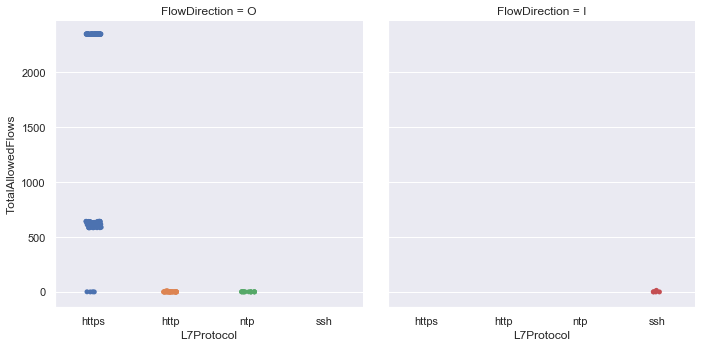

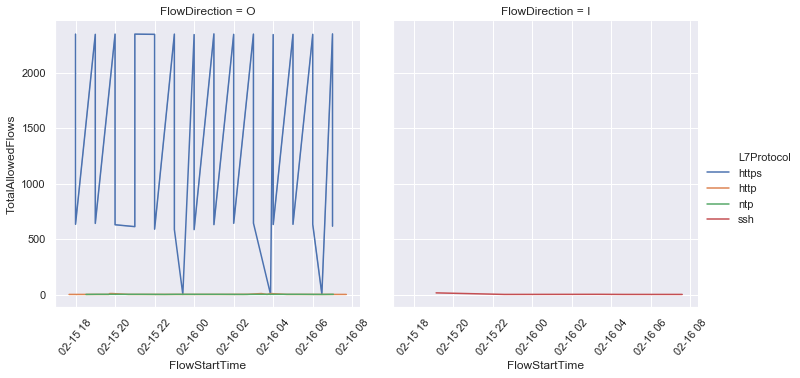

In [235]:
import warnings

                   

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
    sns.catplot(x="L7Protocol", y="TotalAllowedFlows", col="FlowDirection", data=az_net_comms_df)
    sns.relplot(x="FlowStartTime", y="TotalAllowedFlows", 
                col="FlowDirection", kind="line", 
                hue="L7Protocol", data=az_net_comms_df).set_xticklabels(rotation=50)

#### Isolated SSH traffice

In [236]:
az_net_comms_df.query('FlowDirection == \'I\' & L7Protocol == \'ssh\'')[net_default_cols]

,FlowStartTime,FlowEndTime,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows
11,2019-02-16 07:35:07,2019-02-16 07:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
47,2019-02-16 04:35:07,2019-02-16 04:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
73,2019-02-16 03:22:41,2019-02-16 03:51:53,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,2.0
108,2019-02-15 22:35:07,2019-02-15 22:35:07,None,,None,13.67.35.176,10.0.3.4,T,ssh,22.0,I,0.0,1.0
144,2019-02-15 19:08:07,2019-02-15 19:51:16,None,,None,13.67.35.176,10.0.3.4,T,ssh,22.0,I,0.0,15.0


#### Seems suspicious, so Record findings

In [237]:


ext_ip_list = az_net_comms_df.query('FlowDirection == \'I\' & L7Protocol == \'ssh\'')['AllExtIPs'].tolist()

for ip in ext_ip_list:
    if not ip:
        continue
    # Check IP is not already in our list of entities
    if ip in [curr_ip.Address for curr_ip in alert_ip_entities]:
        continue
    ip_entity = asi.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    
    alert_ip_entities.append(ip_entity)
    
add_observation(Observation(caption='Outlier SSH session on Linux Host.',
                            description='''Plot of in/out flows shows unexpected ssh inbound. 
Ip Address confirmed as logon source for SSH.''',
                            item = az_net_comms_df.query('FlowDirection == \'I\' & L7Protocol == \'ssh\''),
                            link='net_flow_graphs'))


### Interactive Flow Timeline

In [238]:

asidisp.display_timeline(data=az_net_comms_df.query('AllowedOutFlows > 0'),
                         overlay_data=az_net_comms_df.query('AllowedInFlows > 0'),
                         alert=security_alert, title='Network Flows (out=blue, in=green)',
                         time_column='FlowStartTime',
                         source_columns=['FlowType', 'AllExtIPs', 'L7Protocol', 'FlowDirection'],
                         height=300)

Loading BokehJS ...

Alert start time =  2019-02-16 03:23:54


<a id='geomap_lx_ips'></a>[Contents](#toc)
## GeoLocation Mapping

In [239]:


ip_locs_in = set()
ip_locs_out = set()
for _, row in az_net_comms_df.iterrows():
    ip = row.AllExtIPs

    if ip in ip_locs_in or ip in ip_locs_out or not ip:
        continue
    ip_entity = asi.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    if not ip_entity.Location:
        continue
    ip_entity.AdditionalData['protocol'] = row.L7Protocol
    if row.FlowDirection == 'I':
        ip_locs_in.add(ip_entity)
    else:
        ip_locs_out.add(ip_entity)

flow_map = create_ip_map()
display(HTML('<h3>External IP Addresses communicating with host</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand'))
display(HTML('Location markers: Blue = outbound, Purple = inbound, Green = Host'))

icon_props = {'color': 'green'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=inv_host_entity.public_ips,
                            **icon_props)
icon_props = {'color': 'blue'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=ip_locs_out,
                            **icon_props)
icon_props = {'color': 'purple'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=ip_locs_in,
                            **icon_props)

display(flow_map)


### Look at 'Denied' Flows - who's trying to get in from where?
#### Optional and can take a long time

In [ ]:


# Comment this out to run automatically
if False:
    az_ip_where = f'''
    | where (VMIPAddress in ({alert_host_ip_list}) 
            or SrcIP in ({alert_host_ip_list}) 
            or DestIP in ({alert_host_ip_list}) 
            )'''

    az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                      start = ip_q_times.start,
                                                      end = ip_q_times.end)
    %kql -query az_net_query_byip
    az_net_comms_all_df = _kql_raw_result_.to_dataframe()

    ip_all = set()
    ip_locs_in_allow = set()
    ip_locs_out_allow = set()
    ip_locs_in_deny = set()
    ip_locs_out_deny = set()
    for _, row in az_net_comms_all_df.iterrows():
        if not row.PublicIPs:
            continue
        for ip in row.PublicIPs:
            if ip in ip_all:
                continue
            ip_all.add(ip)
            ip_entity = asi.IpAddress(Address=ip)
            iplocation.lookup_ip(ip_entity=ip_entity)
            if not ip_entity.Location:
                print("No location information for IP: ", ip)
                continue
            ip_entity.AdditionalData['protocol'] = row.L7Protocol
            if row.FlowDirection == 'I':
                if row.AllowedInFlows > 0:
                    ip_locs_in_allow.add(ip_entity)
                elif row.DeniedInFlows > 0:
                    ip_locs_in_deny.add(ip_entity)
            else:
                if row.AllowedOutFlows > 0:
                    ip_locs_out_allow.add(ip_entity)
                elif row.DeniedOutFlows > 0:
                    ip_locs_out_deny.add(ip_entity)

    flow_map = create_ip_map()
    display(HTML('<h3>External IP Addresses Blocked and Allowed communicating with host</h3>'))
    display(HTML('Numbered circles indicate multiple items - click to expand.'))
    display(HTML('Location markers: Blue = outbound, Purple = inbound, Red = in denied, Cyan = out denied.'))


    icon_props = {'color': 'purple'}
    flow_map = add_ip_cluster(folium_map=flow_map,
                                ip_entities=ip_locs_in_allow,
                                **icon_props)
    icon_props = {'color': 'blue'}
    flow_map = add_ip_cluster(folium_map=flow_map,
                                ip_entities=ip_locs_out_allow,
                                **icon_props)
    icon_props = {'color': 'red'}
    flow_map = add_ip_cluster(folium_map=flow_map,
                                ip_entities=ip_locs_in_deny,
                                **icon_props)
    icon_props = {'color': 'cyan'}
    flow_map = add_ip_cluster(folium_map=flow_map,
                                ip_entities=ip_locs_out_deny,
                                **icon_props)
    display(flow_map)

### DNS Activity Includes any of these IPs?

In [ ]:


dns_query =r'''
DnsEvents
| where ClientIP in ({ip_list})
'''.format(ip_list=', '.join([f'\'{ip.Address}\'' for ip in alert_ip_entities]))

%kql -query dns_query
dns_df = _kql_raw_result_.to_dataframe()
dns_df

<a id='other_hosts_to_ips'></a>[Contents](#toc)
## Have any other hosts been communicating with this address(es)?

In [240]:


ip_q_times = asi.QueryTime(units='day', max_before=10, before=3, after=1, max_after=10, origin_time=security_alert.StartTimeUtc)
ip_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [241]:


alert_ips = {'\'{}\''.format(i.Address) for i in alert_ip_entities}
alert_host_ip_list = ','.join(alert_ips)

az_ip_where = f'| where AllExtIPs in ({alert_host_ip_list})'

az_net_query_by_pub_ip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                       start = ip_q_times.start,
                                                       end = ip_q_times.end)

%kql -query az_net_query_by_pub_ip
az_net_ext_comms_df = _kql_raw_result_.to_dataframe()
az_net_ext_comms_df[net_default_cols]

# az_net_ext_comms_df.groupby(['VMName', 'L7Protocol'])['AllowedOutFlows','AllowedInFlows','DeniedInFlows','DeniedOutFlows'].sum()

,FlowStartTime,FlowEndTime,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows
0,2019-02-16 19:35:07,2019-02-16 19:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
1,2019-02-16 13:35:07,2019-02-16 13:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
2,2019-02-16 16:35:07,2019-02-16 16:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
3,2019-02-16 10:35:07,2019-02-16 10:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
4,2019-02-16 07:35:07,2019-02-16 07:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
5,2019-02-16 04:35:07,2019-02-16 04:35:07,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0
6,2019-02-16 03:23:54,2019-02-16 03:24:10,msticalertslxvm2,10.0.3.4,[13.67.35.176],,,T,http,80.0,O,9.0,0.0
7,2019-02-16 03:51:57,2019-02-16 03:52:13,None,,None,10.0.3.4,23.97.60.214,T,http,80.0,O,9.0,0.0
8,2019-02-16 03:10:55,2019-02-16 03:24:44,None,,None,23.97.60.214,10.0.3.5,T,ms-wbt-server,3389.0,I,0.0,6.0
9,2019-02-16 03:07:26,2019-02-16 03:07:35,None,,None,23.97.60.214,10.0.3.5,T,ms-wbt-server,3389.0,I,0.0,0.0


In [243]:


inv_host_ips = [ent.Address for ent in inv_host_entity.private_ips]
inv_host_ips += [ent.Address for ent in inv_host_entity.public_ips]

alert_ips = [ip.Address for ip in alert_ip_entities]

known_ips = inv_host_ips + alert_ips

# Ips can be in one of 4 columns!
def find_new_ips(known_ips, row):
    new_ips = set()
    if row.VMIPAddress and row.VMIPAddress not in known_ips:
        new_ips.add(row.VMIPAddress)
    if row.SrcIP and row.SrcIP not in known_ips:
        new_ips.add(row.SrcIP)
    if row.DestIP and row.DestIP not in known_ips:
        new_ips.add(row.DestIP)
    if row.PublicIPs:
        for pub_ip in row.PublicIPs:
            if pub_ip not in known_ips:
                new_ips.add(pub_ip)
    if new_ips:            
        return list(new_ips)

new_ips_all = az_net_ext_comms_df.apply(lambda x: find_new_ips(known_ips, x), axis=1).dropna()
new_ips = set()
for ip in [ip for item in new_ips_all for ip in item]:
    new_ips.add(ip)
display(Markdown(f'#### {len(new_ips)} unseen IP Address found in this data: {list(new_ips)}'))

#### 1 unseen IP Address found in this data: ['10.0.3.5']

### Note you should re-run this section for each new IP Address found to determine who it belongs to

In [244]:
items = list(new_ips)
ip_w = widgets.Select(options=items, 
                   description='Select ip address to search for',
                   value=items[0] if items else None,
                   **WIDGET_DEFAULTS)
display(ip_w)

Select(description='Select ip address to search for', layout=Layout(width='95%'), options=('10.0.3.5',), style…

In [245]:


vm_ip = ip_w.value
aznet_query = '''
AzureNetworkAnalytics_CL 
| where PrivateIPAddresses_s has \'{vm_ip}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s,
    VirtualMachine = VirtualMachine_s
| extend Host = split(VirtualMachine, '/')[-1]
'''.format(vm_ip=vm_ip)
%kql -query aznet_query
az_net_df = _kql_raw_result_.to_dataframe()
if len(az_net_df) > 0:
    host_name = az_net_df['Host'].at[0]

oms_heartbeat_query = '''
Heartbeat
| where ComputerIP == \'{vm_ip}\'
| top 1 by TimeGenerated desc nulls last
| project Computer, ComputerIP, OSType, OSMajorVersion, OSMinorVersion, ResourceId, RemoteIPCountry, 
RemoteIPLatitude, RemoteIPLongitude, SourceComputerId
'''.format(vm_ip=vm_ip)
%kql -query oms_heartbeat_query
oms_heartbeat_df = _kql_raw_result_.to_dataframe()
if len(oms_heartbeat_df) > 0:
    host_name = oms_heartbeat_df['Computer'].at[0]
    

# Get the host entity and add this IP and system info to the 
try:
    if not victim_host_entity:
        victim_host_entity = asi.Host()
        victim_host_entity.HostName = host_name
except NameError:
    victim_host_entity = asi.Host()
    victim_host_entity.HostName = host_name

def convert_to_ip_entities(ip_str):
    ip_entities = []
    if ip_str:
        if ',' in ip_str:
            addrs = ip_str.split(',')
        elif ' ' in ip_str:
            addrs = ip_str.split(' ')
        else:
            addrs = [ip_str]
        for addr in addrs:
            ip_entity = asi.IpAddress()
            ip_entity.Address = addr.strip()
            iplocation.lookup_ip(ip_entity=ip_entity)
            ip_entities.append(ip_entity)
    return ip_entities

# Add this information to our inv_host_entity
if len(az_net_df) == 1:
    priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
    victim_host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

    pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
    victim_host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)

retrieved_address = [ip.Address for ip in victim_host_entity.properties['public_ips']]
if len(oms_heartbeat_df) == 1:
    if oms_heartbeat_df['ComputerIP'].loc[0]:
        oms_address = oms_heartbeat_df['ComputerIP'].loc[0]
        if oms_address not in retrieved_address:
            ip_entity = asi.IpAddress()
            ip_entity.Address = oms_address
            iplocation.lookup_ip(ip_entity=ip_entity)
            inv_host_entity.properties['public_ips'].append(ip_entity)
        
    victim_host_entity.OSFamily = oms_heartbeat_df['OSType'].loc[0]
    victim_host_entity.AdditionalData['OSMajorVersion'] = oms_heartbeat_df['OSMajorVersion'].loc[0]
    victim_host_entity.AdditionalData['OSMinorVersion'] = oms_heartbeat_df['OSMinorVersion'].loc[0]
    victim_host_entity.AdditionalData['SourceComputerId'] = oms_heartbeat_df['SourceComputerId'].loc[0]

print(f'Found New Host Entity {victim_host_entity.HostName}\n')
print(victim_host_entity)

add_observation(Observation(caption=f'Second victim host identified {victim_host_entity.HostName}',
                            description='Description of host entity shown in attachment.',
                            item=victim_host_entity,
                            link='other_hosts_to_ips'))

Found New Host Entity msticalertswin1

{ 'HostName': 'msticalertswin1',
  'Type': 'host',
  'private_ips': [{"Address": "10.0.3.5", "Type": "ipaddress"}],
  'public_ips': [ {"Address": "40.76.43.124", "Location": {"CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163, "Type": "geolocation"}, "Type": "ipaddress"}]}


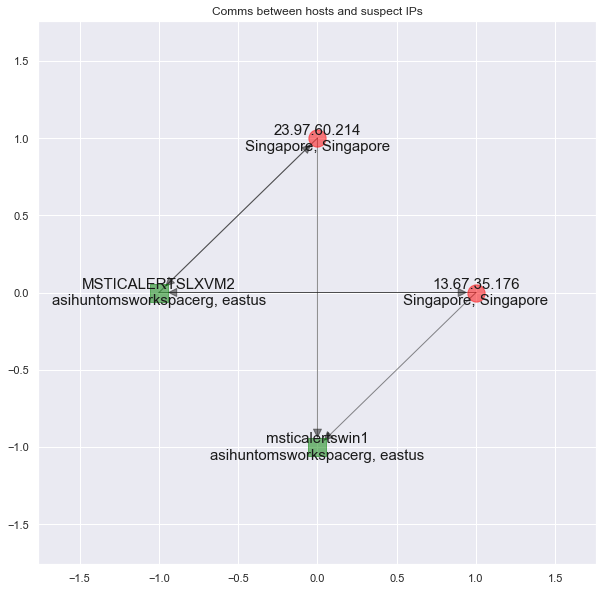

In [246]:


sns.set()
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

ip_graph = nx.DiGraph(id='IPGraph')

def add_vm_node(graph, host_entity):
    vm_name = host_entity.HostName
    vm_ip = host_entity.private_ips[0].Address
    vm_desc = f'{host_entity.HostName}\n{row.ResourceGroup}, {row.VMRegion}'
    ip_graph.add_node(vm_ip, name=vm_name, description=vm_desc,
                      node_type='host')

for ip_entity in alert_ip_entities:
    if 'Location' in ip_entity:
        ip_desc = f'{ip_entity.Address}\n{ip_entity.Location.City}, {ip_entity.Location.CountryName}'
    else:
        ip_desc = 'unknown location'
    ip_graph.add_node(ip_entity.Address, name=ip_entity.Address, description=ip_desc, node_type='ip')

add_vm_node(ip_graph, inv_host_entity)
add_vm_node(ip_graph, victim_host_entity)


def add_edges(graph, row): 
    dest_ip = row.DestIP if row.DestIP else row.VMIPAddress
    if row.SrcIP:
        src_ip = row.SrcIP
        ip_graph.add_edge(src_ip, dest_ip)
    else:
        for ip in row.PublicIPs:
            src_ip = ip
            ip_graph.add_edge(src_ip, dest_ip)

    
# Add edges from network data
az_net_ext_comms_df.apply(lambda x: add_edges(ip_graph, x),axis=1)

src_node = [n for (n, node_type) in
            nx.get_node_attributes(ip_graph, 'node_type').items()
            if node_type == 'ip']
vm_nodes = [n for (n, node_type) in
            nx.get_node_attributes(ip_graph, 'node_type').items()
            if node_type == 'host']

# now draw them in subsets  using the `nodelist` arg
plt.rcParams['figure.figsize'] = (10, 10)
plt.margins(x=0.3, y=0.3)
plt.title('Comms between hosts and suspect IPs')
pos = nx.circular_layout(ip_graph)
nx.draw_networkx_nodes(ip_graph, pos, nodelist=src_node,
                       node_color='red', alpha=0.5, node_shape='o')
nx.draw_networkx_nodes(ip_graph, pos, nodelist=vm_nodes,
                       node_color='green', alpha=0.5, node_shape='s',
                       s=400)
nlabels = nx.get_node_attributes(ip_graph, 'description')
nx.relabel_nodes(ip_graph, nlabels)
nx.draw_networkx_labels(ip_graph, pos, nlabels, font_size=15)
nx.draw_networkx_edges(ip_graph, pos, alpha=0.5, arrows=True, arrowsize=20);


<a id='other_host_investigate'></a>[Contents](#toc)
# Other Hosts Communicating with IP

<a id='host_logons'></a>[Contents](#toc)
## Check Host Logons

In [247]:


from msticpy.asitools.query_defns import DataFamily, DataEnvironment
params_dict = {}
params_dict.update(security_alert.query_params)
params_dict['host_filter_eq'] = f'Computer has \'{victim_host_entity.HostName}\''
params_dict['host_filter_neq'] = f'Computer !has \'{victim_host_entity.HostName}\''
params_dict['host_name'] = victim_host_entity.HostName
if victim_host_entity.OSFamily == 'Linux':
    params_dict['data_family'] = DataFamily.LinuxSecurity
    params_dict['path_separator'] = '/'
else:
    params_dict['data_family'] = DataFamily.WindowsSecurity
    params_dict['path_separator'] = '\\'

# set the origin time to the time of our alert
logon_query_times = asi.QueryTime(units='day', origin_time=security_alert.origin_time,
                                  before=5, after=1, max_before=20, max_after=20)
logon_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

Number of input events: 195

Number of clustered events: 10

#### Distinct host logon patterns

### Account Logon
Account:  SYSTEM
Account Domain:  NT AUTHORITY
Logon Time:  2019-02-17 02:56:17.830000
Logon type: 5 (Service)
User Id/SID:  S-1-5-18
    SID S-1-5-18 is LOCAL_SYSTEM
Session id '0x3e7'  System logon session

Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  -
Logon status:  

### Account Logon
Account:  ian
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-02-16 03:24:41.980000
Logon type: 3 (Network)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-1120
    SID S-1-5-21-996632719-2361334927-4038480536-1120 is local machine or domain account
Session id '0x25d84ea'  
Subject (source) account:  -/-
Logon process:  NtLmSsp 
Authentication:  NTLM
Source IpAddress:  23.97.60.214
Source Host:  MSTICRemoteWin1
Logon status:  

### Account Logon
Account:  DWM-4
Account Domain:  Window Manager
Logon Time:  2019-02-16 03:24:49.093000
Logon type: 2 (Interactive)
User Id/SID:  S-1-5

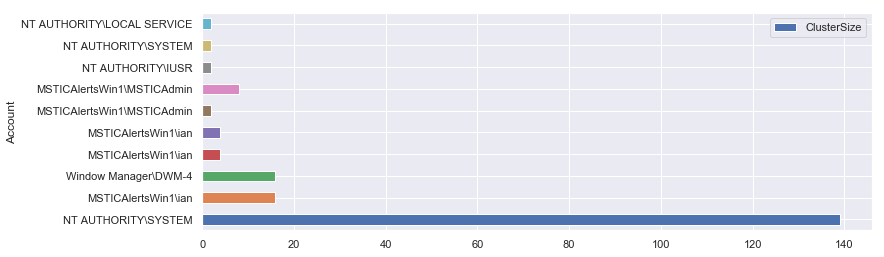

In [248]:


from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

host_logons = qry.list_host_logons(provs=[logon_query_times], **params_dict)


if len(host_logons) > 0:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonIdNum'] = host_logons.apply(lambda x: _string_score(x.TargetLogonId), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                           max_cluster_distance=0.0001)
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (12, 4)
    clus_logons.plot.barh(x="Account", y="ClusterSize")

    display(Markdown(f'Number of input events: {len(host_logons)}'))
    display(Markdown(f'Number of clustered events: {len(clus_logons)}'))
    display(Markdown('#### Distinct host logon patterns'))
    clus_logons.sort_values('TimeGenerated')
    asidisp.display_logon_data(clus_logons)
else:
    display(Markdown('No logon events found for host.'))

<a id='victim2_logon_types'></a>
### Classification of Logon Types by Account

In [250]:


display(Markdown('### Counts of logon events by logon type.'))
display(Markdown('Min counts for each logon type highlighted.'))
logon_by_type = (host_logons[['Account', 'LogonType', 'EventID']]
                .groupby(['Account','LogonType']).count().unstack()
                .fillna(0)
                .style
                .background_gradient(cmap='viridis', low=.5, high=0)
                .format("{0:0>3.0f}"))
display(logon_by_type)
key = 'logon type key = {}'.format('; '.join([f'{k}: {v}' for k,v in asi.nbdisplay._WIN_LOGON_TYPE_MAP.items()]))
display(Markdown(key))

display(Markdown('### Logon Timeline.'))
asidisp.display_timeline(data=host_logons, 
                         alert=security_alert, 
                         source_columns=['Account', 'LogonType', 'TimeGenerated'],
                         title='All Host Logons')

add_observation(Observation(caption='RDP Logons seen for victim #2',
                            description='Logons by logon type.',
                            item=logon_by_type,
                            link='victim2_logon_types'))

### Counts of logon events by logon type.

Min counts for each logon type highlighted.

logon type key = 0: Unknown; 2: Interactive; 3: Network; 4: Batch; 5: Service; 7: Unlock; 8: NetworkCleartext; 9: NewCredentials; 10: RemoteInteractive; 11: CachedInteractive

### Logon Timeline.

Loading BokehJS ...

Alert start time =  2019-02-16 03:23:54


<a id='failed_logons'></a>[Contents](#toc)
## Check for Failed Logons

In [251]:


failedLogons = qry.list_host_logon_failures(provs=[logon_query_times], **params_dict)
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host between {security_alert.start} and {security_alert.start}'))
else:
    display(failedLogons)
    add_observation(Observation(caption='Logon failures seen for victim #2',
                            description=f'{len(failedLogons)} Logons seen.',
                            item=failedLogons,
                            link='failed_logons'))

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-14 04:23:55.400,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-13 16:28:05.417,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-12 20:28:38.637,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,ian,MSTICAlertsWin1,S-1-0-0,,seclogo,2,Negotiate,0xc000006d,::1,MSTICAlertsWin1
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-16 00:06:02.193,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,ian,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1120,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,2,Negotiate,0xc000006d,-,MSTICAlertsWin1
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-15 04:09:38.523,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1


<a id='examine_win_logon_sess'></a>[Contents](#toc)
## Examine a Logon Session

### Select a Logon ID To Examine

In [255]:


import re
dist_logons = clus_logons.sort_values('TimeGenerated')[['TargetUserName', 'TimeGenerated', 
                                                        'LastEventTime', 'LogonType', 
                                                        'ClusterSize']]
items = dist_logons.apply(lambda x: (f'{x.TargetUserName}:    '
                                     f'(logontype={x.LogonType})   '
                                     f'timerange={x.TimeGenerated} - {x.LastEventTime}    '
                                     f'count={x.ClusterSize}'),
                          axis=1).values.tolist()
def get_selected_logon_cluster(selected_item):
    acct_match = re.search(r'(?P<acct>[^:]+):\s+\(logontype=(?P<l_type>[^)]+)', selected_item)
    if acct_match:
        acct = acct_match['acct']
        l_type = int(acct_match['l_type'])
        return host_logons.query('TargetUserName == @acct and LogonType == @l_type')

def get_selected_logon(selected_item):
    logon_list_regex = r'''
(?P<acct>[^:]+):\s+
\(logontype=(?P<logon_type>[^)]+)\)\s+
\(timestamp=(?P<time>[^)]+)\)\s+
logonid=(?P<logonid>[0-9a-fx)]+)
'''
    acct_match = re.search(logon_list_regex, selected_item, re.VERBOSE)
    if acct_match:
        acct = acct_match['acct']
        logon_type = int(acct_match['logon_type'])
        time_stamp = pd.to_datetime(acct_match['time'])
        logon_id = acct_match['logonid']
        return host_logons.query('TargetUserName == @acct and LogonType == @logon_type'
                                 ' and TargetLogonId == @logon_id')
    
logon_wgt = asi.SelectString(description='Select logon cluster to examine', 
                             item_list=items, height='200px', width='100%', auto_display=True)

Select(description='Select logon cluster to examine', layout=Layout(height='200px', width='100%'), options=('S…

In [257]:


selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

def view_logon(x=''):
    global selected_logon
    selected_logon = get_selected_logon(x)
    display(get_selected_logon(x))
    

items = selected_logon_cluster.sort_values('TimeGenerated').apply(lambda x: (f'{x.TargetUserName}:    '
                                        f'(logontype={x.LogonType})   '
                                        f'(timestamp={x.TimeGenerated})    '
                                        f'logonid={x.TargetLogonId}'),
                             axis=1).values.tolist()
w = widgets.Select(options=items, description='Select logon instance to examine', **WIDGET_DEFAULTS)
    
interactive(view_logon, x=w)

interactive(children=(Select(description='Select logon instance to examine', layout=Layout(width='95%'), optio…

<a id='process_clustering'></a>[Contents](#toc)
## Unusual Processes on Host - Clustering
Sometimes you don't have a source process to work with. Other times it's just useful to see what else is going on on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

You can display the raw output of this by looking at the *processes_on_host* dataframe. Just copy this into a new cell and hit Ctrl-Enter.

Usually though, the results return a lot of very repetitive and unintersting system processes so we attempt to cluster these to make the view easier to negotiate. 
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

In [258]:


# Calculate time range based on the logons from previous section
logon_time = selected_logon_cluster['TimeGenerated'].min()
last_logon_time = selected_logon_cluster['TimeGenerated'].max()
time_diff = int((last_logon_time - logon_time).total_seconds() / (60 * 60) + 2)

# set the origin time to the time of our alert
proc_query_times = asi.QueryTime(units='hours', origin_time=logon_time,
                           before=1, after=time_diff, max_before=20, max_after=20)
proc_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [259]:


from msticpy.sectools.eventcluster import dbcluster_events, add_process_features
print('Getting process events...', end='')
processes_on_host = qry.list_processes(provs=[proc_query_times], **params_dict)
print('done')
print('Clustering...', end='')
feature_procs = add_process_features(input_frame=processes_on_host,
                                     path_separator=params_dict['path_separator'])

feature_procs['accountNum'] = feature_procs.apply(lambda x: _string_score(x.Account), axis=1)
# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                     'accountNum',
                                                                     'isSystemSession'],
                                                    max_cluster_distance=0.0001)
print('done')
print('Number of input events:', len(feature_procs))
print('Number of clustered events:', len(clus_events))
(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                          'NewProcessName', 'CommandLine', 
                                          'ClusterSize', 'commandlineTokensFull',
                                          'pathScore', 'isSystemSession']]
    .sort_values('ClusterSize', ascending=False))
print('done')


Getting process events...done
Clustering...done
Number of input events: 1964
Number of clustered events: 150
done


### View processes used in login session

In [260]:


selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

def view_logon_sess(x=''):
    global selected_logon
    selected_logon = get_selected_logon(x)
    display(selected_logon)
    logonId = selected_logon['TargetLogonId'].iloc[0]
    sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
                                          [['NewProcessName', 'CommandLine', 'TargetLogonId']]
                  .drop_duplicates())
    display(sess_procs)
    

items = selected_logon_cluster.sort_values('TimeGenerated').apply(lambda x: (f'{x.TargetUserName}:    '
                                        f'(logontype={x.LogonType})   '
                                        f'(timestamp={x.TimeGenerated})    '
                                        f'logonid={x.TargetLogonId}'),
                             axis=1).values.tolist()
sess_w = widgets.Select(options=items, description='Select logon instance to examine', **WIDGET_DEFAULTS)
    
interactive(view_logon_sess, x=sess_w)

interactive(children=(Select(description='Select logon instance to examine', layout=Layout(width='95%'), optio…

### Save Selected Session as Observation

In [ ]:


if selected_logon is not None:
    display(Markdown('**Attacker Logon Session selected**'))
    display(selected_logon)
    logonid = selected_logon['TargetLogonId'].iloc[0]
    logon_time = selected_logon['TimeGenerated'].iloc[0]
    subj_account = asi.Account(src_event=selected_logon.iloc[0], role='subject')
    tgt_account = asi.Account(src_event=selected_logon.iloc[0], role='target')
    logon_session = asi.HostLogonSession(src_event=selected_logon.iloc[0])
    logon_session.Account = tgt_account
    logon_session.SessionId = logonid
    logon_session.Host = inv_host_entity
    display(Markdown('**Entities:**'))
    print('Subject Account:\n', subj_account)
    print('Target Account Session:\n', logon_session)
    
    add_observation(Observation(caption='Logon session identified for attacker IP',
                            description=f'Logon session for account {logon_session.Account.Name}',
                            item=logon_session,
                            link='examine_win_logon_sess'))

<a id='process_session'></a>[Contents](#toc)
### Processes for Selected LogonId

In [ ]:
logonId = selected_logon['TargetLogonId'].iloc[0]
sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
                                          [['TimeGenerated', 'NewProcessName', 'CommandLine']])

display(sess_procs)
add_observation(Observation(caption='Attacker commands on Victim 2',
                            description=f'Processes run in Attacker session',
                            item=sess_procs,
                            link='process_session'))

### Clustered Version of Previous Query - collapsing duplicates

In [ ]:
display(clus_events.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
        [['TimeGenerated', 'NewProcessName', 'CommandLine', 'ClusterSize']])

### Optional (for the curious) - View clustering stats

In [ ]:

# change False to True in the if statement to see this
if False:
    proc_plot = sns.catplot(y="processName", x="commandlineTokensFull", 
                            data=feature_procs.sort_values('processName'),
                            kind='box', height=10)
    proc_plot.fig.suptitle('All Processes - Variability of Commandline Tokens', x=1, y=1)

    plt.rcParams['figure.figsize'] = (5, 15)
    clus_plot = clus_events[['processName', 
                             'ClusterId', 
                             'ClusterSize']].groupby(['processName', 
                                                      'ClusterId']).sum().plot.barh()
    plt.title('Clustered Processes - cluster size of each command line pattern');

<a id='other_win_events'></a>[Contents](#toc)
## Other Events on the Host

In [261]:


all_events_base_qry = '''
SecurityEvent
| where Computer =~ '{host}'
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where {where_filter}
'''
all_events_qry = all_events_base_qry.format(host=params_dict['host_name'],
                                            start=proc_query_times.start,
                                            end=proc_query_times.end,
                                            where_filter='EventID != 4688 and EventID != 4624')

%kql -query all_events_qry
all_events_df = _kql_raw_result_.to_dataframe()
display(all_events_df[['Account', 'Activity', 'TimeGenerated']].groupby(['Account', 'Activity']).count())

add_observation(Observation(caption='System account modifications during attack.',
                            description='Count of event types seen on system',
                            item=all_events_df[['Account', 'Activity', 'TimeGenerated']].groupby(['Account', 'Activity']).count(),
                            link='other_win_events'))

TimeGenerated
Account                    Activity                                                                                            
                           4776 - The domain controller attempted to validate the credentials for an account.                 7
                           5058 - Key file operation.                                                                        13
                           5061 - Cryptographic operation.                                                                   13
MSTICAlertsWin1\MSTICAdmin 4634 - An account was logged off.                                                                  1
                           4798 - A user's local group membership was enumerated.                                             1
                           8002 - A process was allowed to run.                                                              51
MSTICAlertsWin1\ian        4625 - An account failed to log on.                                                                1
                           4634 - An account was logged off.                                                                  7
                           4672 - Special privileges assigned to new logon.                                                  11
                           4720 - A user account was created.                                                                 1
                           4722 - A user account was enabled.                                                                 1
                           4724 - An attempt was made to reset an account's password.                                         2
                           4726 - A user account was deleted.                                                                 1
                           4728 - A member was added to a security-enabled global group.                                      1
                           4729 - A member was removed from a security-enabled global group.                                  1
                           4732 - A member was added to a security-enabled local group.                                       2
                           4733 - A member was removed from a security-enabled local group.                                   2
                           4738 - A user account was changed.                                                                 3
                           4797 - An attempt was made to query the existence of a blank password for an account.              4
                           4798 - A user's local group membership was enumerated.                                            26
                           4799 - A security-enabled local group membership was enumerated                                    3
                           8002 - A process was allowed to run.                                                             226
NT AUTHORITY\SYSTEM        4672 - Special privileges assigned to new logon.                                                  18
                           8002 - A process was allowed to run.                                                               6
WORKGROUP\MSTICAlertsWin1$ 4648 - A logon was attempted using explicit credentials.                                           5
                           4798 - A user's local group membership was enumerated.                                            84
                           4799 - A security-enabled local group membership was enumerated                                   33
                           5059 - Key migration operation.                                                                   22
Window Manager\DWM-3       4672 - Special privileges assigned to new logon.                                                   2
Window Manager\DWM-4       4634 - An account was logged off.                                                                  2
                  

In [262]:


# Function to convert EventData XML into dictionary and populate columns into DataFrame from previous query result
all_events_df['EventData'].iloc[10]
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ParseError
SCHEMA='http://schemas.microsoft.com/win/2004/08/events/event'
def parse_event_data(row):
    try:
        xdoc = ET.fromstring(row.EventData)
        col_dict = {elem.attrib['Name']: elem.text for elem in xdoc.findall(f'{{{SCHEMA}}}Data')}
        reassigned = set()
        for k, v in col_dict.items():
            if k in row and not row[k]:
                row[k] = v
                reassigned.add(k)
        if reassigned:
            #print('Reassigned: ', ', '.join(reassigned))
            for k in reassigned:
                col_dict.pop(k)
        return col_dict
    except ParseError:
        return None

all_events_df['EventProperties'] = all_events_df.apply(parse_event_data, axis=1)


<a id='o365'></a>[Contents](#toc)
# Office 365 Activity

In [263]:


# set the origin time to the time of our alert
o365_query_times = asi.QueryTime(units='hours', origin_time=security_alert.origin_time,
                           before=1, after=10, max_before=20, max_after=20)
o365_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

### Execute queries to get the data

In [264]:


print('Running queries...', end=' ')
# Queries
ad_changes_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType == 'AzureActiveDirectory'
| where Operation in ('Add service principal.',
                      'Change user password.', 
                      'Add user.', 
                      'Add member to role.')
| where UserType == 'Regular' 
| project OfficeId, TimeGenerated, Operation, OrganizationId, 
          OfficeWorkload, ResultStatus, OfficeObjectId, 
          UserId = tolower(UserId), ClientIP, ExtendedProperties
'''.format(start = o365_query_times.start, end=o365_query_times.end)
%kql -query ad_changes_query
ad_changes_df = _kql_raw_result_.to_dataframe()


office_ops_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| union (
    OfficeActivity 
    | where TimeGenerated >= datetime({start})
    | where TimeGenerated <= datetime({end})
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
'''.format(start = o365_query_times.start, end=o365_query_times.end)
%kql -query office_ops_query
office_ops_df = _kql_raw_result_.to_dataframe()

office_ops_summary_query = '''
let timeRange=ago(30d);
let officeAuthentications = OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
officeAuthentications
| union (
    OfficeActivity 
    | where TimeGenerated >= timeRange
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
| extend RecordOp = strcat(RecordType, '-', Operation)
| summarize OpCount=count() by RecordType, Operation, UserId, UserAgent, ClientIP, bin(TimeGenerated, 1h)
// render timeline
'''.format(start = o365_query_times.start, end=o365_query_times.end)
%kql -query office_ops_summary_query
office_ops_summary_df = _kql_raw_result_.to_dataframe()
# %kql -query office_ops_query
# office_ops_df = _kql_raw_result_.to_dataframe()

office_logons_query = '''
let timeRange=ago(30d);
let officeAuthentications = OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
let lookupWindow = 1d;
let lookupBin = lookupWindow / 2.0; 
officeAuthentications | project-rename Start=TimeGenerated
| extend TimeKey = bin(Start, lookupBin)
| join kind = inner (
    officeAuthentications
    | project-rename End=TimeGenerated
    | extend TimeKey = range(bin(End - lookupWindow, lookupBin), bin(End, lookupBin), lookupBin)
    | mvexpand TimeKey to typeof(datetime)
) on UserAgent, TimeKey
| project timeSpan = End - Start, UserId, ClientIP , UserAgent , Start, End
| summarize dcount(ClientIP) by  UserAgent
| where dcount_ClientIP > 1
| join kind=inner (  
officeAuthentications
| summarize minTime=min(TimeGenerated), maxTime=max(TimeGenerated) by UserId, UserAgent, ClientIP
) on UserAgent
'''
%kql -query office_logons_query
office_logons_df = _kql_raw_result_.to_dataframe()

print('done.')

Running queries... done.


<a id='o365_match_ip'></a>
### Any IP Addresses in our alert IPs that match Office Activity?

In [265]:
# Any IP Addresses in our alert IPs that match?


for ip in alert_ip_entities:
    susp_o365_activities = office_ops_df[office_ops_df['ClientIP'] == ip.Address]
    susp_o365_summ = (office_ops_df[office_ops_df['ClientIP'] == ip.Address]
                         [['OfficeId', 'UserId', 'RecordType', 'Operation']]
                         .groupby(['UserId', 'RecordType', 'Operation']).count()
                         .rename(columns={'OfficeId': 'OperationCount'}))
    
    display(Markdown(f'### Activity for {ip.Address}'))
    display(susp_o365_summ)
    
    if len(susp_o365_summ) > 0:
        add_observation(Observation(caption=f'O365 activity from suspected attacker IP {ip.Address}',
                                    description=f'Summarized operation count for each user/service/operation type',
                                    item=susp_o365_summ,
                                    link='o365_match_ip'))

### Activity for 13.67.35.176

,,,OperationCount
UserId,RecordType,Operation,


### Activity for 23.97.60.214

OperationCount
UserId                           RecordType                   Operation                      
ianh@M365x054215.onmicrosoft.com AzureActiveDirectoryStsLogon UserLoggedIn                 17
ianh@m365x054215.onmicrosoft.com AzureActiveDirectoryStsLogon UserLoginFailed               3
                                 SharePoint                   PageViewed                    1
                                 SharePointFileOperation      FileAccessed                  4
                                                              FileDownloaded               47
                                                              FilePreviewed                 3

In [266]:


for susp_ip in [ip.Address for ip in alert_ip_entities]:

    display(Markdown(f'### Timeline of operations originating from suspect IP Address: {susp_ip}'))

    display(Markdown(f'**{susp_ip}**'))
    suspect_ip_ops = office_ops_df[office_ops_df['ClientIP'] == susp_ip]
    sel_op_type='FileDownloaded'
    asidisp.display_timeline(data=suspect_ip_ops, title=f'Operations from {susp_ip} (all=blue, {sel_op_type}=green)',
                             overlay_data=suspect_ip_ops.query('Operation == @sel_op_type'),
                            source_columns=['UserId', 'RecordType', 'Operation'])
    
    # Uncomment line below to see all activity
    # display(suspect_ip_ops.sort_values('TimeGenerated', ascending=True).head())


### Timeline of operations originating from suspect IP Address: 13.67.35.176

**13.67.35.176**

Loading BokehJS ...

### Timeline of operations originating from suspect IP Address: 23.97.60.214

**23.97.60.214**

Loading BokehJS ...

<a id="o356_high_freq"></a>
### Look for high-frequency operations - like automated or bulk uploads/downloads
#### Anything above or approaching 1 operation/sec is likely an automated or bulk operation

In [267]:


timed_slice_ops = office_ops_df[['RecordType', 'TimeGenerated', 'Operation',
       'OrganizationId', 'UserType', 'OfficeWorkload',
       'ResultStatus', 'OfficeObjectId', 'UserId', 'ClientIP', 'Start_Time']]
timed_slice_ops2 = timed_slice_ops.set_index('TimeGenerated')

hi_freq_ops = (timed_slice_ops2[['UserId', 'ClientIP', 'Operation', 'RecordType']]
                .groupby(['UserId', 'ClientIP', 'RecordType', 'Operation']).resample('10S').count()
                .query('RecordType > 10')
                .drop(['ClientIP', 'UserId', 'RecordType'], axis=1)
                .assign(OpsPerSec = lambda x: x.Operation / 10)
                .rename(columns={'Operation': 'Operation Count'}))

if len(hi_freq_ops) > 0:
    display(hi_freq_ops)
    add_observation(Observation(caption=f'O365 bulk/high freq operations seen',
                                    description=f'Summarized operation count bulk actions',
                                    item=hi_freq_ops,
                                    link='o356_high_freq'))

Operation Count  \
UserId                           ClientIP     RecordType              Operation      TimeGenerated                          
ianh@m365x054215.onmicrosoft.com 23.97.60.214 SharePointFileOperation FileDownloaded 2019-02-16 03:45:00               17   
                                                                                     2019-02-16 03:45:10               17   

                                                                                                          OpsPerSec  
UserId                           ClientIP     RecordType              Operation      TimeGenerated                   
ianh@m365x054215.onmicrosoft.com 23.97.60.214 SharePointFileOperation FileDownloaded 2019-02-16 03:45:00        1.7  
                                                                                     2019-02-16 03:45:10        1.7

## Other Background Data for O365

In [ ]:


display(Markdown('### IPs and User Agents - frequency of use'))
office_ops_df['UserId'] = office_ops_df['UserId'].str.lower()
display(Markdown('Distinct IPs by num of operations'))
display(office_ops_df[['ClientIP', 'Operation']].groupby(['ClientIP']).count())
display(Markdown('Distinct UserAgents by num of operations'))
office_ops_df[['UserAgent', 'Operation']].groupby(['UserAgent']).count()


In [ ]:


off_ip_locs = (office_ops_df[['ClientIP']]
                   .drop_duplicates()
                   .apply(lambda x: 
                          iplocation.lookup_ip(ip_address=x.ClientIP)[1]
                          if x.ClientIP and x.ClientIP != '<null>' else None, axis=1)
                   .tolist())
ip_locs = [ip_list[0] for ip_list in off_ip_locs if ip_list]
    
flow_map = create_ip_map()
display(HTML('<h3>External IP Addresses seen in Office Activity</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand.'))


icon_props = {'color': 'purple'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=ip_locs,
                            **icon_props)
display(flow_map)   

In [ ]:


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(Markdown('### Change in rate of Activity Class (RecordType) and Operation'))
    sns.relplot(data=office_ops_summary_df, x='TimeGenerated', y='OpCount', kind='line', aspect=2, 
                hue='RecordType')
    sns.relplot(data=office_ops_summary_df.query('RecordType == "SharePointFileOperation"'), 
                x='TimeGenerated', y='OpCount', hue='Operation', kind='line', aspect=2)



In [ ]:


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(Markdown('### Identify Users/IPs with largest operation count'))
    office_ops_summary_df['UserId'] = office_ops_summary_df['UserId'].str.lower()

    sns.catplot(data=office_ops_summary_df, x='UserId', y='OpCount', 
                hue='Operation', aspect=2).set_xticklabels(rotation=30)
    office_ops_summary_df.pivot_table('OpCount', index=['ClientIP', 'UserId'], 
                                      columns='Operation').style.bar(color='orange', align='mid')

### Extract distinctive events from O365 Operations

In [ ]:


from msticpy.sectools.eventcluster import (dbcluster_events, 
                                           add_process_features, 
                                           char_ord_score,
                                           token_count,
                                           delim_count)

feature_office_ops = office_ops_df.copy()
feature_office_ops['ip_num'] = feature_office_ops.apply(lambda x: char_ord_score(x, 'ClientIP'), axis=1)
feature_office_ops['ua_tokens'] = feature_office_ops.apply(lambda x: char_ord_score(x, 'UserAgent'), axis=1)
feature_office_ops['oid_tokens'] = feature_office_ops.apply(lambda x: char_ord_score(x, 'OfficeObjectId'), axis=1)

# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clustered_ops, dbcluster, x_data) = dbcluster_events(data=feature_office_ops,
                                                      cluster_columns=['ip_num', 
                                                                     'ua_tokens', 
                                                                     'oid_tokens'],
                                                      time_column='TimeGenerated',
                                                      max_cluster_distance=0.0001)
print('Number of input events:', len(feature_office_ops))
print('Number of clustered events:', len(clustered_ops))
(clustered_ops[['TimeGenerated', 'RecordType',
                'Operation', 'UserId', 'UserAgent', 'ClusterSize',
                'OfficeObjectId']]
    .query('ClusterSize <= 2')
    .sort_values('ClusterSize', ascending=True))

<a id='summary'></a>[Contents](#toc)
# Summary

In [268]:
for observation in observation_list.values():
    display_observation(observation)
    

### Alert IPs Location

Geolocation of alert IPs

[Go to details](#basic_ip_checks)

[{"Address": "13.67.35.176", "Location": {"CountryCode": "SG", "CountryName": "Singapore", "State": "Central Singapore Community Development Council", "City": "Singapore", "Longitude": 103.8558, "Latitude": 1.2931, "Type": "geolocation"}, "Type": "ipaddress"},
 {"Address": "23.97.60.214", "Location": {"CountryCode": "SG", "CountryName": "Singapore", "State": "Central Singapore Community Development Council", "City": "Singapore", "Longitude": 103.8558, "Latitude": 1.2931, "Type": "geolocation"}, "Type": "ipaddress"}]

### Threat Intel Report on IP(s)

Threat intelligence report found on alert host ext IP

[Go to details](#check_ip_ti)

,TimeGenerated,ExternalIndicatorId_s,ThreatType_s,Description_s,Active_s,TrafficLightProtocolLevel_s,ConfidenceScore_s,ThreatSeverity_s,ExpirationDateTime_t,IndicatorId_s,NetworkIP_s,Type
0,2019-02-07 01:15:18.400,TestBotnetIndicator1549501989MS531,Botnet,This is a test botnet indicator generated in RFC5737 documentation space. Take no action on any ...,True,Green,0,0,2019-02-07 02:13:08.531,6eb18b18cf93deb3bd8d22f56160dbb2392fa99de510c710e00d297f5c5ba8db,203.0.113.5,ThreatIntelSample_CL


### Login events with source Ip addresses

2 logins with external addresses

[Go to details](#linux_login_ips)

,Computer,TimeGenerated,pid,ses,acct,addr,exe,hostname,msg,res_cred,ses_cred,terminal
63,MSTICAlertsLxVM2,2019-02-16 03:51:55.865,22838,190715,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh
169,MSTICAlertsLxVM2,2019-02-16 03:23:17.590,19803,190671,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh


### Outlier SSH session on Linux Host.

Plot of in/out flows shows unexpected ssh inbound. 
Ip Address confirmed as logon source for SSH.

[Go to details](#net_flow_graphs)

,TenantId,TimeGenerated,FlowStartTime,FlowEndTime,FlowIntervalEndTime,FlowType,ResourceGroup,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows,DeniedInFlows,DeniedOutFlows,RemoteRegion,VMRegion,AllExtIPs,TotalAllowedFlows
11,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-16 08:35:23.882,2019-02-16 07:35:07,2019-02-16 07:35:07,2019-02-16 08:00:00,InterVNet,None,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0,0.0,0.0,,,23.97.60.214,1.0
47,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-16 05:37:53.023,2019-02-16 04:35:07,2019-02-16 04:35:07,2019-02-16 05:00:00,InterVNet,None,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,1.0,0.0,0.0,,,23.97.60.214,1.0
73,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-16 04:37:27.325,2019-02-16 03:22:41,2019-02-16 03:51:53,2019-02-16 04:00:00,InterVNet,None,None,,None,23.97.60.214,10.0.3.4,T,ssh,22.0,I,0.0,2.0,0.0,0.0,,,23.97.60.214,2.0
108,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-15 23:32:05.274,2019-02-15 22:35:07,2019-02-15 22:35:07,2019-02-15 23:00:00,InterVNet,None,None,,None,13.67.35.176,10.0.3.4,T,ssh,22.0,I,0.0,1.0,0.0,0.0,,,13.67.35.176,1.0
144,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-15 20:30:32.942,2019-02-15 19:08:07,2019-02-15 19:51:16,2019-02-15 20:00:00,InterVNet,None,None,,None,13.67.35.176,10.0.3.4,T,ssh,22.0,I,0.0,15.0,0.0,0.0,,,13.67.35.176,15.0


### Second victim host identified msticalertswin1

Description of host entity shown in attachment.

[Go to details](#other_hosts_to_ips)

{"HostName": "msticalertswin1", "private_ips": [{"_entity_properties": {"AdditionalData": {}, "Address": "10.0.3.5"}}], "public_ips": [{"_entity_properties": {"AdditionalData": {}, "Address": "40.76.43.124", "Location": {"_entity_properties": {"AdditionalData": {}, "CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163}}}}], "Type": "host"}

### RDP Logons seen for victim #2

Logons by logon type.

[Go to details](#victim2_logon_types)

### Logon failures seen for victim #2

5 Logons seen.

[Go to details](#failed_logons)

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-14 04:23:55.400,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-13 16:28:05.417,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-12 20:28:38.637,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,ian,MSTICAlertsWin1,S-1-0-0,,seclogo,2,Negotiate,0xc000006d,::1,MSTICAlertsWin1
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-16 00:06:02.193,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,ian,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1120,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,2,Negotiate,0xc000006d,-,MSTICAlertsWin1
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-15 04:09:38.523,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1


### Logon session identified for attacker IP

Logon session for account ian

[Go to details](#examine_win_logon_sess)

{"StartTimeUtc": {}, "EndTimeUtc": {}, "SessionId": "0x1cfd78d", "Account": {"Name": "ian", "Sid": "S-1-5-21-996632719-2361334927-4038480536-1120", "LogonId": "0x1cfd78d", "Type": "account"}, "Host": {"AdditionalData": {"OSMajorVersion": "18", "OSMinorVersion": "04", "SourceComputerId": "44623fb0-bd5f-49ea-84d1-56aa11ab8a25"}, "HostName": "MSTICALERTSLXVM2", "private_ips": [{"_entity_properties": {"AdditionalData": {}, "Address": "10.0.3.4"}}], "public_ips": [{"_entity_properties": {"AdditionalData": {}, "Address": "104.211.30.1", "Location": {"_entity_properties": {"AdditionalData": {}, "CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163}}}}], "OSFamily": "Linux", "Type": "host"}, "Type": "hostlogonsession"}

### Attacker commands on Victim 2

Processes run in Attacker session

[Go to details](#process_session)

,TimeGenerated,NewProcessName,CommandLine
337,2019-02-16 04:38:47.097,C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,"""C:\Program Files (x86)\Google\Chrome\Application\chrome.exe"" --type=utility --field-trial-handl..."
413,2019-02-16 03:54:26.030,C:\Windows\System32\taskhostw.exe,taskhostw.exe USER
495,2019-02-16 03:00:00.593,C:\Windows\System32\AppHostRegistrationVerifier.exe,C:\Windows\system32\AppHostRegistrationVerifier.exe
496,2019-02-16 03:00:00.833,C:\Windows\System32\AppHostRegistrationVerifier.exe,C:\Windows\system32\AppHostRegistrationVerifier.exe
509,2019-02-16 03:26:59.267,C:\Windows\System32\net.exe,net localgroup administrators abai$ /delete
510,2019-02-16 03:26:59.290,C:\Windows\System32\net1.exe,C:\Windows\system32\net1 localgroup administrators abai$ /delete
511,2019-02-16 03:26:59.317,C:\Windows\System32\net.exe,net user qf938$ /delete
512,2019-02-16 03:26:59.330,C:\Windows\System32\net1.exe,C:\Windows\system32\net1 user qf938$ /delete
513,2019-02-16 03:26:59.357,C:\Windows\System32\cmd.exe,cmd /c echo End Security Demo tasks
524,2019-02-16 03:28:44.100,C:\Windows\System32\TSTheme.exe,C:\Windows\system32\TSTheme.exe -Embedding


### System account modifications during attack.

Count of event types seen on system

[Go to details](#other_win_events)

TimeGenerated
Account                    Activity                                                                                            
                           4776 - The domain controller attempted to validate the credentials for an account.                 7
                           5058 - Key file operation.                                                                        13
                           5061 - Cryptographic operation.                                                                   13
MSTICAlertsWin1\MSTICAdmin 4634 - An account was logged off.                                                                  1
                           4798 - A user's local group membership was enumerated.                                             1
                           8002 - A process was allowed to run.                                                              51
MSTICAlertsWin1\ian        4625 - An account failed to log on.                                                                1
                           4634 - An account was logged off.                                                                  7
                           4672 - Special privileges assigned to new logon.                                                  11
                           4720 - A user account was created.                                                                 1
                           4722 - A user account was enabled.                                                                 1
                           4724 - An attempt was made to reset an account's password.                                         2
                           4726 - A user account was deleted.                                                                 1
                           4728 - A member was added to a security-enabled global group.                                      1
                           4729 - A member was removed from a security-enabled global group.                                  1
                           4732 - A member was added to a security-enabled local group.                                       2
                           4733 - A member was removed from a security-enabled local group.                                   2
                           4738 - A user account was changed.                                                                 3
                           4797 - An attempt was made to query the existence of a blank password for an account.              4
                           4798 - A user's local group membership was enumerated.                                            26
                           4799 - A security-enabled local group membership was enumerated                                    3
                           8002 - A process was allowed to run.                                                             226
NT AUTHORITY\SYSTEM        4672 - Special privileges assigned to new logon.                                                  18
                           8002 - A process was allowed to run.                                                               6
WORKGROUP\MSTICAlertsWin1$ 4648 - A logon was attempted using explicit credentials.                                           5
                           4798 - A user's local group membership was enumerated.                                            84
                           4799 - A security-enabled local group membership was enumerated                                   33
                           5059 - Key migration operation.                                                                   22
Window Manager\DWM-3       4672 - Special privileges assigned to new logon.                                                   2
Window Manager\DWM-4       4634 - An account was logged off.                                                                  2
                  

### O365 activity from suspected attacker IP 23.97.60.214

Summarized operation count for each user/service/operation type

[Go to details](#o365_match_ip)

OperationCount
UserId                           RecordType                   Operation                      
ianh@M365x054215.onmicrosoft.com AzureActiveDirectoryStsLogon UserLoggedIn                 17
ianh@m365x054215.onmicrosoft.com AzureActiveDirectoryStsLogon UserLoginFailed               3
                                 SharePoint                   PageViewed                    1
                                 SharePointFileOperation      FileAccessed                  4
                                                              FileDownloaded               47
                                                              FilePreviewed                 3

### O365 bulk/high freq operations seen

Summarized operation count bulk actions

[Go to details](#o356_high_freq)

Operation Count  \
UserId                           ClientIP     RecordType              Operation      TimeGenerated                          
ianh@m365x054215.onmicrosoft.com 23.97.60.214 SharePointFileOperation FileDownloaded 2019-02-16 03:45:00               17   
                                                                                     2019-02-16 03:45:10               17   

                                                                                                          OpsPerSec  
UserId                           ClientIP     RecordType              Operation      TimeGenerated                   
ianh@m365x054215.onmicrosoft.com 23.97.60.214 SharePointFileOperation FileDownloaded 2019-02-16 03:45:00        1.7  
                                                                                     2019-02-16 03:45:10        1.7

### Suspicious Process Session on Linux Host.

Attempt to download and run script + recon cmds.

[Go to details](#linux_proc_cluster)

,EventType,TenantId,Computer,mssg_id,TimeGenerated,a0,a1,a2,argc,auid,CommandLine,cwd,egid,euid,NewProcessName,gid,NewProcessId,ProcessId,proctitle,SubjectLogonId,success,SubjectUserSid,processNameLen,processNameTokens,processName,pathScore,pathLogScore,commandlineTokens,commandlineLen,commandlineLogLen,commandlineTokensFull,commandlineScore,commandlineLogScore,isSystemSession,Clustered,ClusterId,ClusterSize,LastEventTime
11103,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.154:8726512,2019-02-16 03:23:19.154,-bash,NaN,NaN,1.0,1001,-bash,/home/dbadmin,1001.0,1001.0,/bin/bash,1001.0,19982,19981.0,-bash,190671,yes,1001,9,3,bash,821,2.914343,1,5,0.698970,1,459,2.661813,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11104,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.158:8726513,2019-02-16 03:23:19.158,groups,NaN,NaN,1.0,1001,groups,/home/dbadmin,1001.0,1001.0,/usr/bin/groups,1001.0,19984,19983.0,groups,190671,yes,1001,15,4,groups,1472,3.167908,1,6,0.778151,0,672,2.827369,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11105,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.162:8726514,2019-02-16 03:23:19.162,/usr/bin/locale-check,C.UTF-8,NaN,2.0,1001,/usr/bin/locale-check C.UTF-8,/home/dbadmin,1001.0,1001.0,/usr/bin/locale-check,1001.0,19986,19985.0,/usr/bin/locale-check C.UTF-8,190671,yes,1001,21,4,locale-check,1979,3.296446,4,29,1.462398,7,2464,3.391641,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11106,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.166:8726515,2019-02-16 03:23:19.166,locale,NaN,NaN,1.0,1001,locale,/home/dbadmin,1001.0,1001.0,/usr/bin/locale,1001.0,19987,19982.0,locale,190671,yes,1001,15,4,locale,1424,3.153510,1,6,0.778151,0,624,2.795185,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11207,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.190:8726516,2019-02-16 03:23:19.190,/bin/sh,/usr/bin/lesspipe,NaN,2.0,1001,/bin/sh /usr/bin/lesspipe,/home/dbadmin,1001.0,1001.0,/bin/dash,1001.0,19990,19989.0,/bin/sh /usr/bin/lesspipe,190671,yes,1001,9,3,dash,823,2.915400,6,25,1.397940,6,2327,3.366796,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11208,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.194:8726517,2019-02-16 03:23:19.194,basename,/usr/bin/lesspipe,NaN,2.0,1001,basename /usr/bin/lesspipe,/home/dbadmin,1001.0,1001.0,/usr/bin/basename,1001.0,19991,19990.0,basename /usr/bin/lesspipe,190671,yes,1001,17,4,basename,1628,3.211654,4,26,1.414973,4,2529,3.402949,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11209,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.194:8726518,2019-02-16 03:23:19.194,dirname,/usr/bin/lesspipe,NaN,2.0,1001,dirname /usr/bin/lesspipe,/home/dbadmin,1001.0,1001.0,/usr/bin/dirname,1001.0,19993,19992.0,dirname /usr/bin/lesspipe,190671,yes,1001,16,4,dirname,1536,3.186391,4,25,1.397940,4,2437,3.386856,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11210,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287399.198:8726519,2019-02-16 03:23:19.198,dircolors,-b,NaN,2.0,1001,dircolors -b,/home/dbadmin,1001.0,1001.0,/usr/bin/dircolors,1001.0,19995,19994.0,dircolors -b,190671,yes,1001,18,4,dircolors,1777,3.249687,1,12,1.079181,2,1152,3.061452,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11215,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287402.522:8726524,2019-02-16 03:23:22.522,ls,--color=auto,NaN,2.0,1001,ls --color=auto,/home/dbadmin,1001.0,1001.0,/bin/ls,1001.0,20000,19982.0,ls --color=auto,190671,yes,1001,7,3,ls,630,2.799341,1,15,1.176091,3,1390,3.143015,False,False,-1.0,1.0,2019-02-16 02:07:01.505
11246,SYSCALL,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsLxVM2,1550287421.754:8726555,2019-02-16 03:23:41.754,NaN,NaN,NaN,NaN,1001,,/home/dbadmin,1001.0,1001.0,/bin/bash,1001.0,20030,19982.0,-bash,190671,no,1001,9,3,bash,821,2.914343,1,0,0.000000,0,0,0.000000,False,False,-1.0,1.0,2019-02-16 02:07:01.505


<a id='appendices'></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [ ]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```